# 1. Data Loading and Initial Inspection

Load Data and Initial Exploration

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data from URL
url = 'https://raw.githubusercontent.com/neilaxu/schulich_data_science/main/MBAN%206750%20HW/hotel_bookings.csv'
hotel_bookings = pd.read_csv(url)

# Display basic information
print(hotel_bookings.shape)
print(hotel_bookings.columns)
print(hotel_bookings.info())
print(hotel_bookings.head())
print(hotel_bookings.tail())

(119390, 32)
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                        

# 2. Preliminary Exploratory Data Analysis (EDA)


Visualize Data Distributions & Correlation Analysis

In [2]:
# Count the number of City and Resort Hotels in hotel_bookings
hotel_counts = hotel_bookings['hotel'].value_counts()

# Display the counts
print("Number of City and Resort Hotels:")
print(hotel_counts)

Number of City and Resort Hotels:
hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


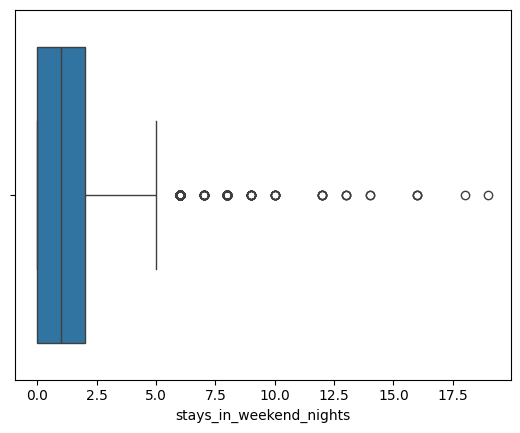

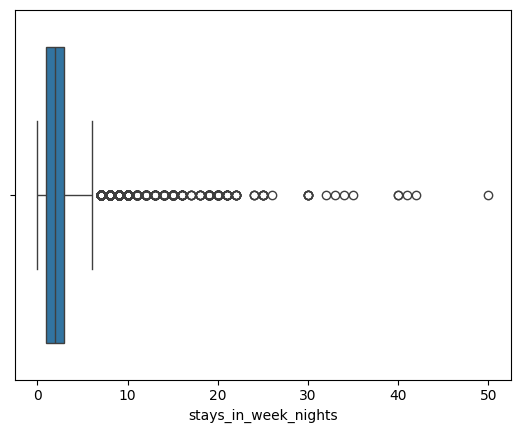

Correlation with is_canceled (Original Features):
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64


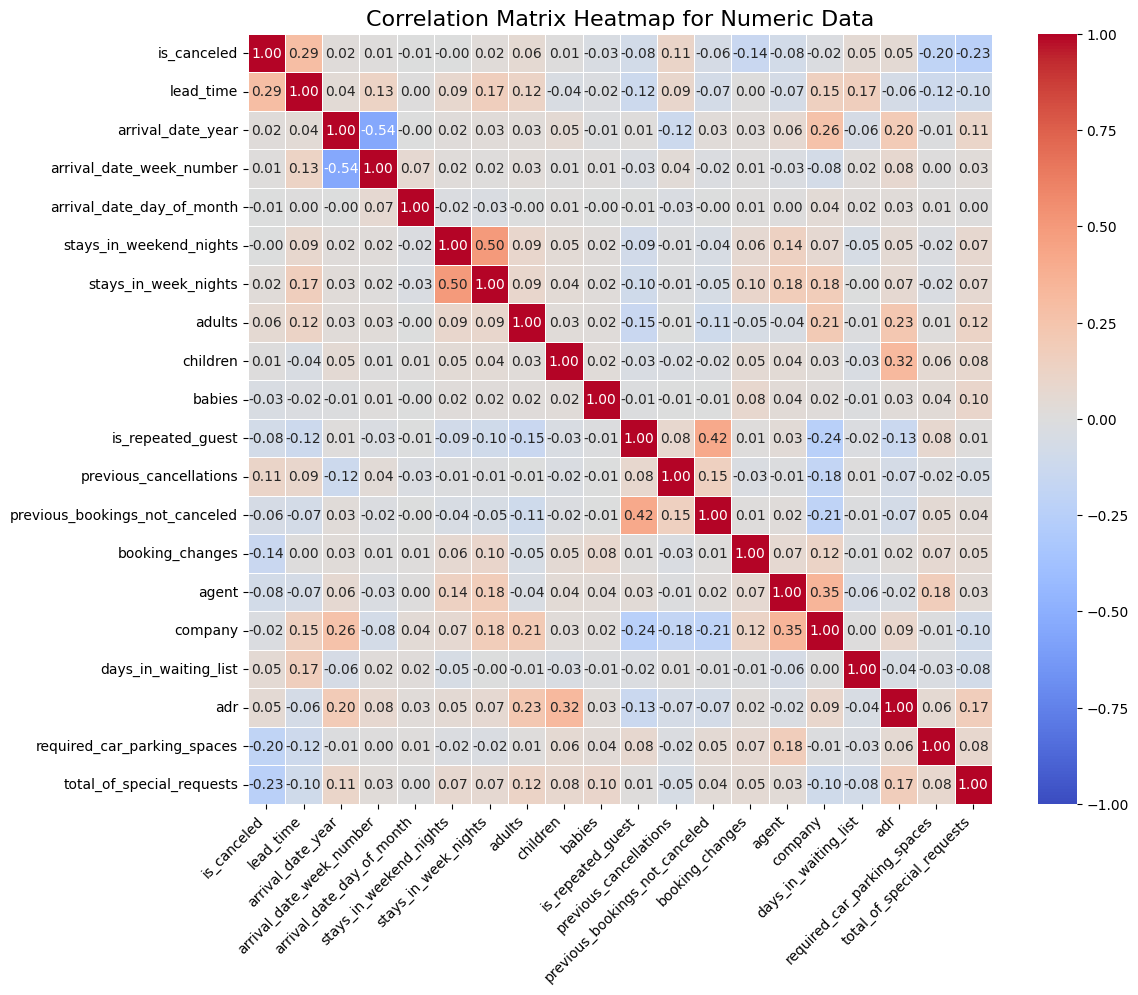

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\837670076.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_corr.values, y=cancellation_corr.index, palette='viridis')


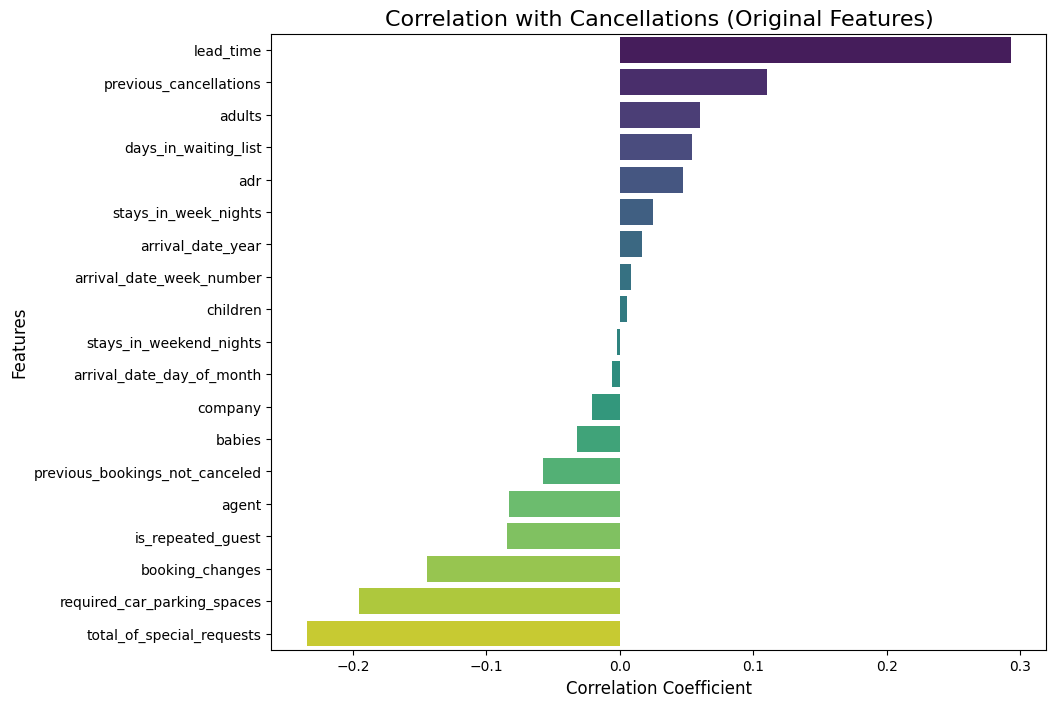

In [3]:
# Boxplots for stays in weekend and week nights
sns.boxplot(x=hotel_bookings['stays_in_weekend_nights'])
plt.show()
sns.boxplot(x=hotel_bookings['stays_in_week_nights'])
plt.show()

# Correlation Analysis
numerical_features = hotel_bookings.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = hotel_bookings[numerical_features].corr()

# Correlation with the target variable
cancellation_corr = corr_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)
print("Correlation with is_canceled (Original Features):")
print(cancellation_corr)

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap for Numeric Data', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Bar plot for correlation with is_canceled
plt.figure(figsize=(10, 8))
sns.barplot(x=cancellation_corr.values, y=cancellation_corr.index, palette='viridis')
plt.title('Correlation with Cancellations (Original Features)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# 3. Data Cleaning

Impute Missing Values and Data Cleaning

In [4]:
# Impute missing values in 'children' with 0
hotel_bookings['children'].fillna(0, inplace=True)

# Prepare columns for KNN imputation
knn_columns = ['customer_type', 'adults', 'lead_time', 'required_car_parking_spaces', 'total_of_special_requests', 'country']
knn_data = hotel_bookings[knn_columns]
knn_data_encoded = pd.get_dummies(knn_data, columns=['customer_type', 'country'], dummy_na=True)

# Perform KNN imputation for 'country'
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = knn_imputer.fit_transform(knn_data_encoded)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=knn_data_encoded.columns)

# Decode one-hot encoded 'country' column
imputed_country_columns = [col for col in knn_imputed_df.columns if 'country_' in col]
imputed_country = knn_imputed_df[imputed_country_columns].idxmax(axis=1).str.replace('country_', '')
hotel_bookings['country'] = imputed_country

# Update 'adults' column: replace 0 with 1
hotel_bookings.loc[hotel_bookings['adults'] == 0, 'adults'] = 1

# Handle 'adr' column
hotel_bookings.loc[hotel_bookings['adr'] < 0, 'adr'] = None
knn_columns_adr = ['adr', 'reserved_room_type', 'meal', 'market_segment', 'distribution_channel']
knn_data_adr = hotel_bookings[knn_columns_adr]
knn_data_adr_encoded = pd.get_dummies(knn_data_adr, columns=['reserved_room_type', 'meal', 'market_segment', 'distribution_channel'], dummy_na=True)

knn_imputer_adr = KNNImputer(n_neighbors=5)
knn_imputed_adr = knn_imputer_adr.fit_transform(knn_data_adr_encoded)
knn_imputed_df_adr = pd.DataFrame(knn_imputed_adr, columns=knn_data_adr_encoded.columns)
hotel_bookings['adr'] = knn_imputed_df_adr['adr']

# Replace extreme outliers in 'adr'
threshold = hotel_bookings['adr'].quantile(0.999)
hotel_bookings.loc[hotel_bookings['adr'] > threshold, 'adr'] = None

# Impute again after removing outliers
knn_imputed_adr = knn_imputer_adr.fit_transform(knn_data_adr_encoded)
knn_imputed_df_adr = pd.DataFrame(knn_imputed_adr, columns=knn_data_adr_encoded.columns)
hotel_bookings['adr'] = knn_imputed_df_adr['adr']


C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\3197619776.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_bookings['children'].fillna(0, inplace=True)


# 4. Feature Engineering

In [5]:
# Merge 'arrival_date_year', 'arrival_date_month', and 'arrival_date_day_of_month' into 'arrival_date'
hotel_bookings['arrival_date_month'] = pd.to_datetime(hotel_bookings['arrival_date_month'], format='%B').dt.month
hotel_bookings['arrival_date'] = pd.to_datetime(hotel_bookings['arrival_date_year'].astype(str) + '-' + 
                                                 hotel_bookings['arrival_date_month'].astype(str) + '-' + 
                                                 hotel_bookings['arrival_date_day_of_month'].astype(str))

# Create 'room_type_change' column
hotel_bookings['room_type_change'] = hotel_bookings.apply(lambda row: 0 if row['reserved_room_type'] == row['assigned_room_type'] else 1, axis=1)

# Calculate 'total_stay_nights'
hotel_bookings['total_stay_nights'] = hotel_bookings['stays_in_weekend_nights'] + hotel_bookings['stays_in_week_nights']

# Split dataset into 'City Hotel' and 'Resort Hotel'
city_hotel = hotel_bookings[hotel_bookings['hotel'] == 'City Hotel']
resort_hotel = hotel_bookings[hotel_bookings['hotel'] == 'Resort Hotel']

# Data Imbalance
city_hotel_imbalance = city_hotel['is_canceled'].value_counts(normalize=True) * 100
resort_hotel_imbalance = resort_hotel['is_canceled'].value_counts(normalize=True) * 100
print("City Hotel 'is_canceled' Data Imbalance:")
print(city_hotel_imbalance)
print("\nResort Hotel 'is_canceled' Data Imbalance:")
print(resort_hotel_imbalance)



City Hotel 'is_canceled' Data Imbalance:
is_canceled
0    58.273037
1    41.726963
Name: proportion, dtype: float64

Resort Hotel 'is_canceled' Data Imbalance:
is_canceled
0    72.236645
1    27.763355
Name: proportion, dtype: float64


check whether the number of 'adults' or number of 'adults'+children + babies' 
is the better X variable to predict cancellation for city hotels

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\2353144404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_hotel['cancel_rate'] = city_hotel['is_canceled']
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\2353144404.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_hotel['total_people'] = city_hotel['adults'] + city_hotel['children'] + city_hotel['babies']


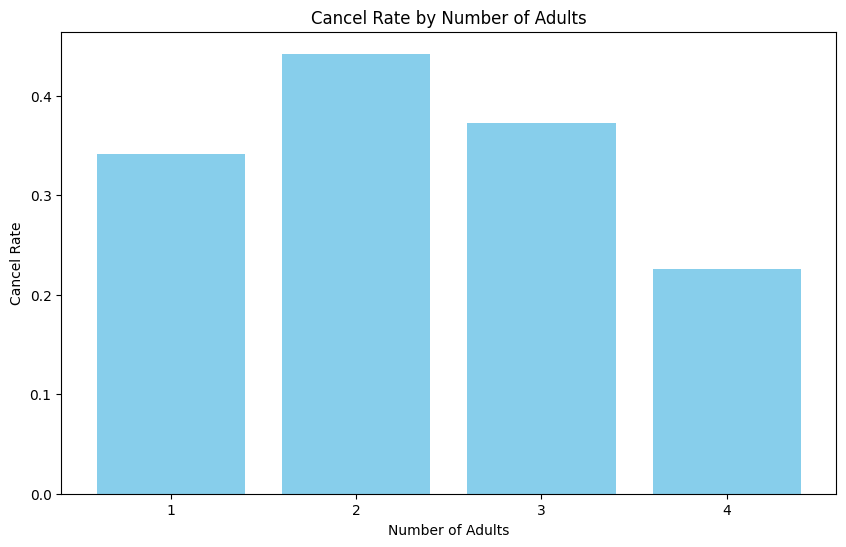

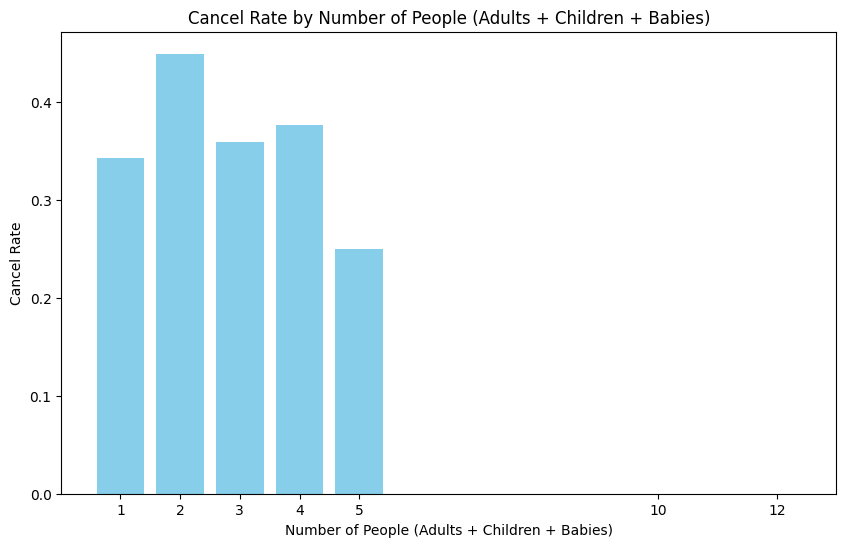

In [6]:
import matplotlib.pyplot as plt

# Calculate cancellation rate for 'adults'
city_hotel['cancel_rate'] = city_hotel['is_canceled']
cancel_rate_adults = city_hotel.groupby('adults')['cancel_rate'].mean().reset_index()

# Calculate cancellation rate for 'adults' + 'children' + 'babies'
city_hotel['total_people'] = city_hotel['adults'] + city_hotel['children'] + city_hotel['babies']
cancel_rate_total_people = city_hotel.groupby('total_people')['cancel_rate'].mean().reset_index()

# Bar Chart 1: x = number of 'adults', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_adults['adults'], cancel_rate_adults['cancel_rate'], color='skyblue')
plt.xlabel('Number of Adults')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Adults')
plt.xticks(cancel_rate_adults['adults'])
plt.show()

# Bar Chart 2: x = number of 'adults' + 'children' + 'babies', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_total_people['total_people'], cancel_rate_total_people['cancel_rate'], color='skyblue')
plt.xlabel('Number of People (Adults + Children + Babies)')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of People (Adults + Children + Babies)')
plt.xticks(cancel_rate_total_people['total_people'])
plt.show()




In [7]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Logistic Regression Model 1: 'adults'
X_adults = city_hotel[['adults']]
y = city_hotel['is_canceled']
log_reg_adults = sm.Logit(y, sm.add_constant(X_adults)).fit()
print(log_reg_adults.summary())

# Logistic Regression Model 2: 'adults' + 'children' + 'babies'
X_total_people = city_hotel[['total_people']]
log_reg_total_people = sm.Logit(y, sm.add_constant(X_total_people)).fit()
print(log_reg_total_people.summary())

Optimization terminated successfully.
         Current function value: 0.678060
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                79330
Model:                          Logit   Df Residuals:                    79328
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                0.001966
Time:                        21:13:59   Log-Likelihood:                -53791.
converged:                       True   LL-Null:                       -53896.
Covariance Type:            nonrobust   LLR p-value:                 5.374e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7286      0.028    -25.835      0.000      -0.784      -0.673
adults         0.2121      0.

from these statistics, for city hotels, we can tell the number of 'adults' can better tell the cancellation than 'adults+children+babies', 
due to its higher coefficient

check whether the number of 'adults' or number of 'adults'+children + babies' 
is the better X variable to predict cancellation for Resort hotels

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\464036412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resort_hotel['cancel_rate'] = resort_hotel['is_canceled']
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\464036412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resort_hotel['total_people'] = resort_hotel['adults'] + resort_hotel['children'] + resort_hotel['babies']


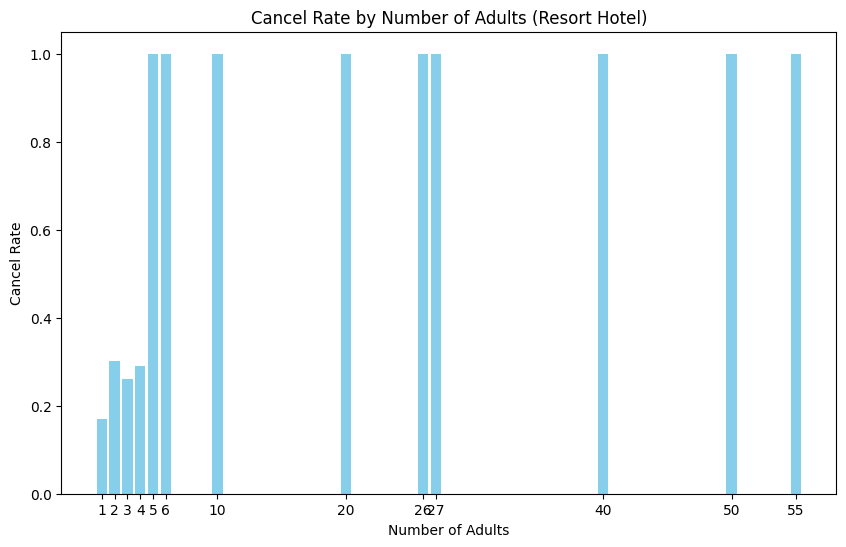

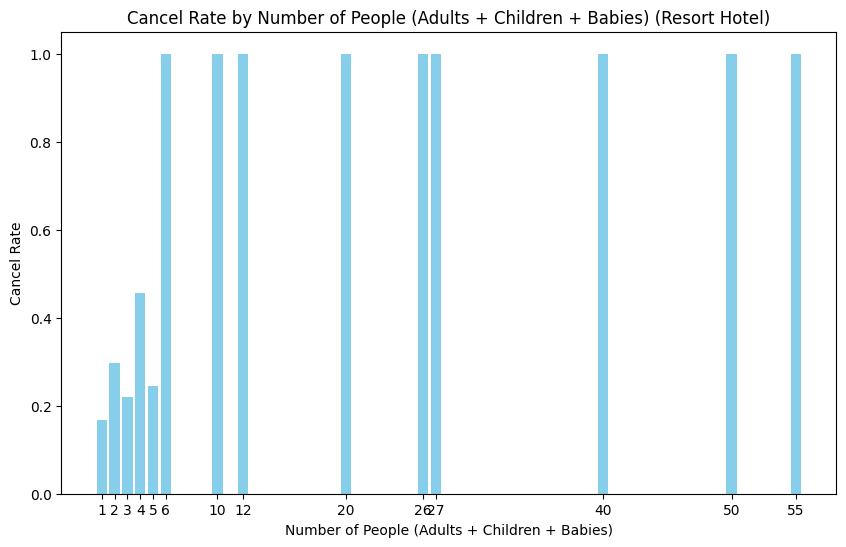

In [8]:
# Calculate cancellation rate for 'adults'
resort_hotel['cancel_rate'] = resort_hotel['is_canceled']
cancel_rate_adults_resort = resort_hotel.groupby('adults')['cancel_rate'].mean().reset_index()

# Calculate cancellation rate for 'adults' + 'children' + 'babies'
resort_hotel['total_people'] = resort_hotel['adults'] + resort_hotel['children'] + resort_hotel['babies']
cancel_rate_total_people_resort = resort_hotel.groupby('total_people')['cancel_rate'].mean().reset_index()

# Bar Chart 1: x = number of 'adults', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_adults_resort['adults'], cancel_rate_adults_resort['cancel_rate'], color='skyblue')
plt.xlabel('Number of Adults')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Adults (Resort Hotel)')
plt.xticks(cancel_rate_adults_resort['adults'])
plt.show()

# Bar Chart 2: x = number of 'adults' + 'children' + 'babies', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_total_people_resort['total_people'], cancel_rate_total_people_resort['cancel_rate'], color='skyblue')
plt.xlabel('Number of People (Adults + Children + Babies)')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of People (Adults + Children + Babies) (Resort Hotel)')
plt.xticks(cancel_rate_total_people_resort['total_people'])
plt.show()


In [9]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Logistic Regression Model 1: 'adults'
X_adults_resort = resort_hotel[['adults']]
y_resort = resort_hotel['is_canceled']
log_reg_adults_resort = sm.Logit(y_resort, sm.add_constant(X_adults_resort)).fit()
print(log_reg_adults_resort.summary())

# Logistic Regression Model 2: 'adults' + 'children' + 'babies'
X_total_people_resort = resort_hotel[['total_people']]
log_reg_total_people_resort = sm.Logit(y_resort, sm.add_constant(X_total_people_resort)).fit()
print(log_reg_total_people_resort.summary())


Optimization terminated successfully.
         Current function value: 0.585780
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                40060
Model:                          Logit   Df Residuals:                    40058
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                0.008337
Time:                        21:14:00   Log-Likelihood:                -23466.
converged:                       True   LL-Null:                       -23664.
Covariance Type:            nonrobust   LLR p-value:                 8.382e-88
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8788      0.051    -36.716      0.000      -1.979      -1.779
adults         0.4900      0.

from these statistics, for resort hotels, we can tell the number of 'adults' can better tell the cancellation than 'adults+children+babies', 
due to its higher coefficient

In [10]:
# Feature Engineering for City Hotel
city_hotel['month_year'] = city_hotel['arrival_date'].dt.to_period('M')
monthly_adults_count = city_hotel.groupby(['month_year', 'arrival_date_year', 'arrival_date_month'])['adults'].sum().reset_index()
median_monthly_adults = monthly_adults_count.groupby('arrival_date_year')['adults'].median().reset_index()
median_monthly_adults.columns = ['arrival_date_year', 'median_adults']
monthly_adults_count = monthly_adults_count.merge(median_monthly_adults, on='arrival_date_year')
monthly_adults_count['month_label'] = monthly_adults_count.apply(lambda row: 'busy month-individual' if row['adults'] > row['median_adults'] else 'slack month-individual', axis=1)
city_hotel = city_hotel.merge(monthly_adults_count[['month_year', 'month_label']], on='month_year', how='left')
print(city_hotel[['arrival_date', 'adults', 'month_label']].head())

# Feature Engineering for Resort Hotel
resort_hotel['month_year'] = resort_hotel['arrival_date'].dt.to_period('M')
monthly_family_count = resort_hotel.groupby(['month_year', 'arrival_date_year', 'arrival_date_month'])['adults'].sum().reset_index()
monthly_family_count['total_people'] = monthly_family_count['adults'] 
median_monthly_family = monthly_family_count.groupby('arrival_date_year')['total_people'].median().reset_index()
median_monthly_family.columns = ['arrival_date_year', 'median_people']
monthly_family_count = monthly_family_count.merge(median_monthly_family, on='arrival_date_year')
monthly_family_count['month_label'] = monthly_family_count.apply(lambda row: 'busy month-family' if row['total_people'] > row['median_people'] else 'slack month-family', axis=1)
resort_hotel = resort_hotel.merge(monthly_family_count[['month_year', 'month_label']], on='month_year', how='left')
print(resort_hotel[['arrival_date', 'adults', 'children', 'babies', 'month_label']].head())

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\526327912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_hotel['month_year'] = city_hotel['arrival_date'].dt.to_period('M')


  arrival_date  adults             month_label
0   2015-07-01       1  slack month-individual
1   2015-07-01       2  slack month-individual
2   2015-07-01       1  slack month-individual
3   2015-07-01       2  slack month-individual
4   2015-07-02       2  slack month-individual
  arrival_date  adults  children  babies         month_label
0   2015-07-01       2       0.0       0  slack month-family
1   2015-07-01       2       0.0       0  slack month-family
2   2015-07-01       1       0.0       0  slack month-family
3   2015-07-01       1       0.0       0  slack month-family
4   2015-07-01       2       0.0       0  slack month-family


C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\526327912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resort_hotel['month_year'] = resort_hotel['arrival_date'].dt.to_period('M')


inmitate the "adult" thing, for city hotel, check 
whether total book nights or week day nights has greater influnce on cancelation

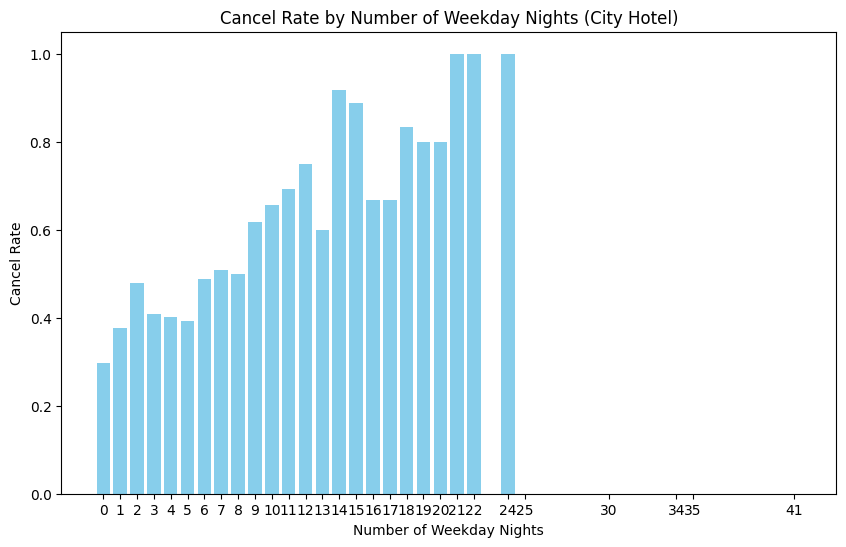

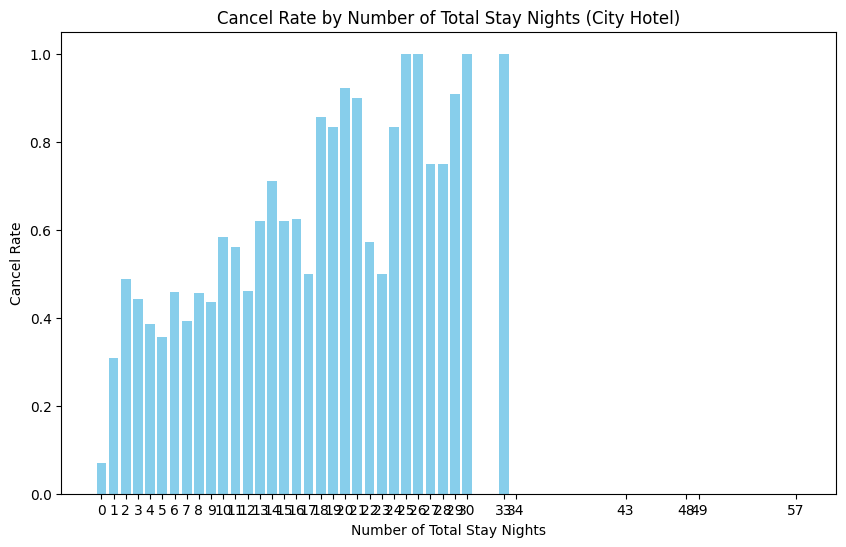

In [11]:
# Calculate cancellation rate for 'stays_in_week_nights'
cancel_rate_week_nights_city = city_hotel.groupby('stays_in_week_nights')['cancel_rate'].mean().reset_index()

# Calculate cancellation rate for 'total_stay_nights'
cancel_rate_total_stay_nights_city = city_hotel.groupby('total_stay_nights')['cancel_rate'].mean().reset_index()

# Bar Chart 1: x = 'stays_in_week_nights', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_week_nights_city['stays_in_week_nights'], cancel_rate_week_nights_city['cancel_rate'], color='skyblue')
plt.xlabel('Number of Weekday Nights')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Weekday Nights (City Hotel)')
plt.xticks(cancel_rate_week_nights_city['stays_in_week_nights'])
plt.show()

# Bar Chart 2: x = 'total_stay_nights', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_total_stay_nights_city['total_stay_nights'], cancel_rate_total_stay_nights_city['cancel_rate'], color='skyblue')
plt.xlabel('Number of Total Stay Nights')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Total Stay Nights (City Hotel)')
plt.xticks(cancel_rate_total_stay_nights_city['total_stay_nights'])
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Logistic Regression Model 1: 'stays_in_week_nights'
X_week_nights_city = city_hotel[['stays_in_week_nights']]
y_city = city_hotel['is_canceled']
log_reg_week_nights_city = sm.Logit(y_city, sm.add_constant(X_week_nights_city)).fit()
print(log_reg_week_nights_city.summary())

# Logistic Regression Model 2: 'total_stay_nights'
X_total_stay_nights_city = city_hotel[['total_stay_nights']]
log_reg_total_stay_nights_city = sm.Logit(y_city, sm.add_constant(X_total_stay_nights_city)).fit()
print(log_reg_total_stay_nights_city.summary())


Optimization terminated successfully.
         Current function value: 0.678212
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                79330
Model:                          Logit   Df Residuals:                    79328
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                0.001741
Time:                        21:14:02   Log-Likelihood:                -53803.
converged:                       True   LL-Null:                       -53896.
Covariance Type:            nonrobust   LLR p-value:                 1.008e-42
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4830      0.013    -36.713      0.000      -0.509      -0.457

so for city hotel, week night stays is the better predictor than total nights due to the higher coefficient, in order to predict cancellation

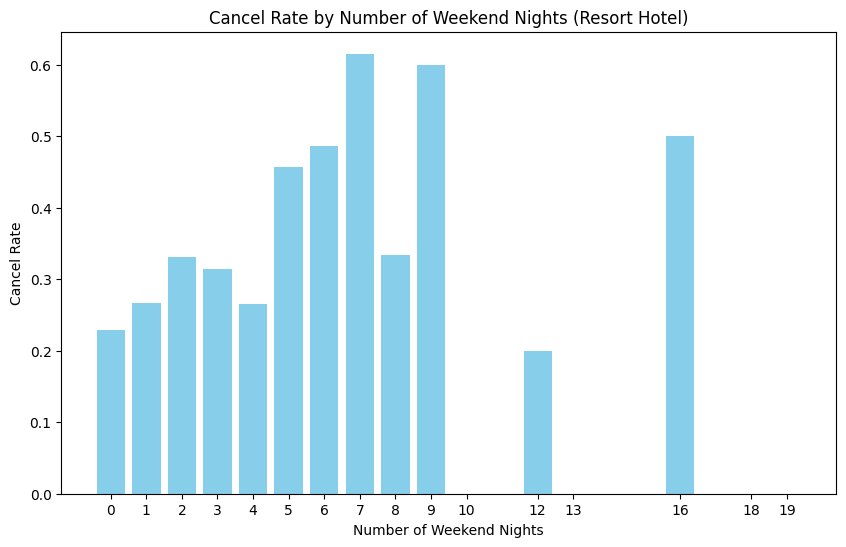

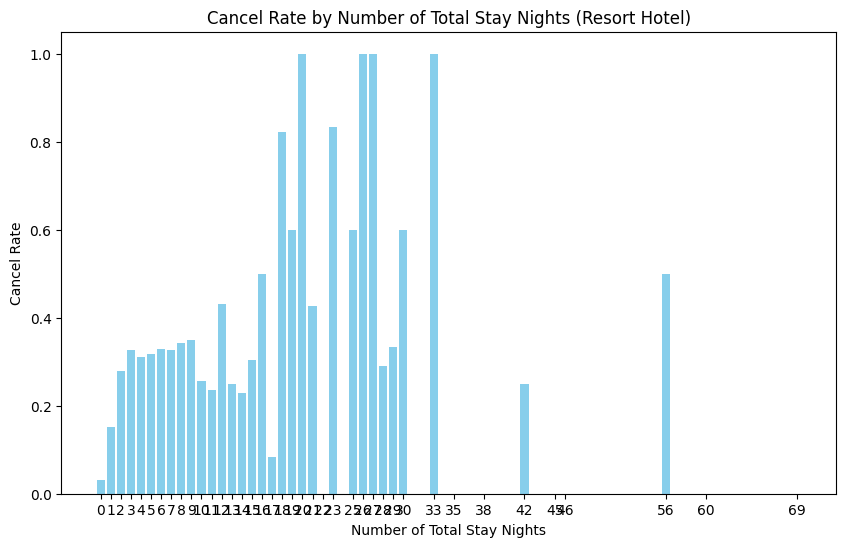

In [13]:
# Calculate cancellation rate for 'stays_in_weekend_nights'
cancel_rate_weekend_nights_resort = resort_hotel.groupby('stays_in_weekend_nights')['cancel_rate'].mean().reset_index()

# Calculate cancellation rate for 'total_stay_nights'
cancel_rate_total_stay_nights_resort = resort_hotel.groupby('total_stay_nights')['cancel_rate'].mean().reset_index()

# Bar Chart 1: x = 'stays_in_weekend_nights', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_weekend_nights_resort['stays_in_weekend_nights'], cancel_rate_weekend_nights_resort['cancel_rate'], color='skyblue')
plt.xlabel('Number of Weekend Nights')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Weekend Nights (Resort Hotel)')
plt.xticks(cancel_rate_weekend_nights_resort['stays_in_weekend_nights'])
plt.show()

# Bar Chart 2: x = 'total_stay_nights', y = 'cancel rate'
plt.figure(figsize=(10, 6))
plt.bar(cancel_rate_total_stay_nights_resort['total_stay_nights'], cancel_rate_total_stay_nights_resort['cancel_rate'], color='skyblue')
plt.xlabel('Number of Total Stay Nights')
plt.ylabel('Cancel Rate')
plt.title('Cancel Rate by Number of Total Stay Nights (Resort Hotel)')
plt.xticks(cancel_rate_total_stay_nights_resort['total_stay_nights'])
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Logistic Regression Model 1: 'stays_in_weekend_nights'
X_weekend_nights_resort = resort_hotel[['stays_in_weekend_nights']]
y_resort = resort_hotel['is_canceled']
log_reg_weekend_nights_resort = sm.Logit(y_resort, sm.add_constant(X_weekend_nights_resort)).fit()
print(log_reg_weekend_nights_resort.summary())

# Logistic Regression Model 2: 'total_stay_nights'
X_total_stay_nights_resort = resort_hotel[['total_stay_nights']]
log_reg_total_stay_nights_resort = sm.Logit(y_resort, sm.add_constant(X_total_stay_nights_resort)).fit()
print(log_reg_total_stay_nights_resort.summary())


Optimization terminated successfully.
         Current function value: 0.587693
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                40060
Model:                          Logit   Df Residuals:                    40058
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                0.005099
Time:                        21:14:04   Log-Likelihood:                -23543.
converged:                       True   LL-Null:                       -23664.
Covariance Type:            nonrobust   LLR p-value:                 2.047e-54
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.1386      0.016    -69.094      0.000      -1.171   

so for resort hotel, weekend night stays is the better predictor than total nights due to the higher coefficient, in order to predict cancellation

# 5. EDA for City and Resort Hotels


Statistics for City Hotel:

Average Lead Time: 109.73572419009201
Average Lead Time for Canceled Bookings: 150.28122167844845
Average Lead Time for Non-Canceled Bookings: 80.70273427360041
Average Previous Cancellations: 0.07974284633808143
Average ADR: 105.30446539770578
Average ADR for Canceled Bookings: 104.6879203673494
Average ADR for Non-Canceled Bookings: 105.74594834299562
Average Booking Changes: 0.18736921719399974
Repeat Guest Cancellation Rate: 0.2170275590551181
Average Lead Time for Repeat Guests: 35.900590551181104
Average Lead Time for Non-Repeat Guests: 111.67669279929623
Average ADR for Repeat Guests: 64.23479330708662
Average ADR for Non-Repeat Guests: 106.38409971797459


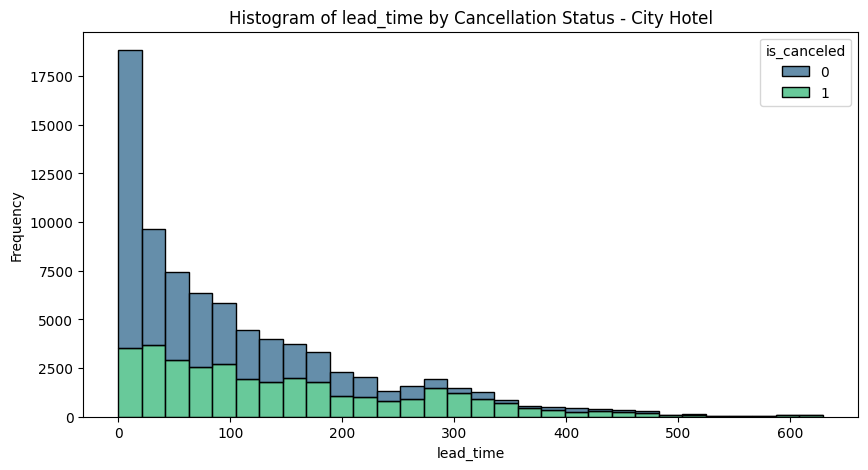

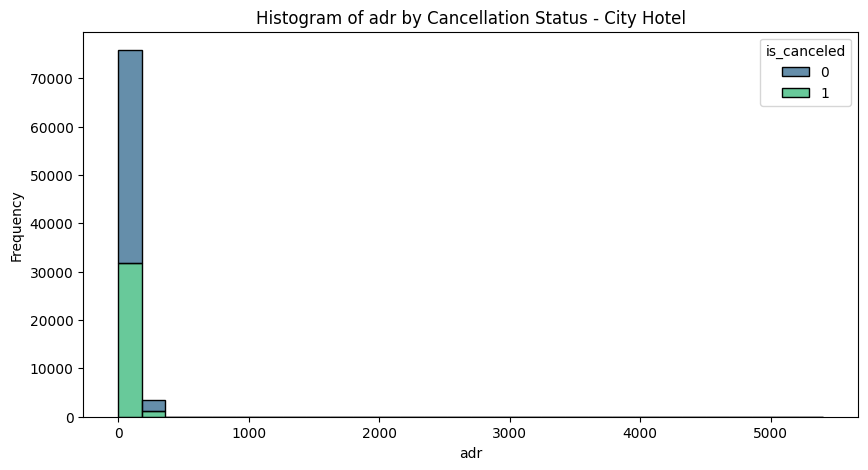

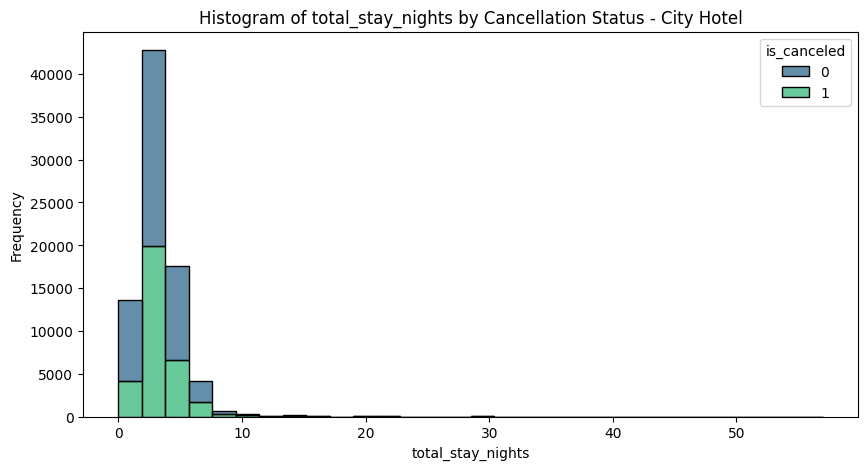


Statistics for Resort Hotel:

Average Lead Time: 92.67568647029456
Average Lead Time for Canceled Bookings: 128.68054306779356
Average Lead Time for Non-Canceled Bookings: 78.83761835648627
Average Previous Cancellations: 0.10172241637543684
Average ADR: 94.95521068397403
Average ADR for Canceled Bookings: 105.7870104297788
Average ADR for Non-Canceled Bookings: 90.79212834335478
Average Booking Changes: 0.2879680479281078
Repeat Guest Cancellation Rate: 0.06242969628796401
Average Lead Time for Repeat Guests: 24.94150731158605
Average Lead Time for Non-Repeat Guests: 95.82158716890444
Average ADR for Repeat Guests: 64.73876827896513
Average ADR for Non-Repeat Guests: 96.35860743952772


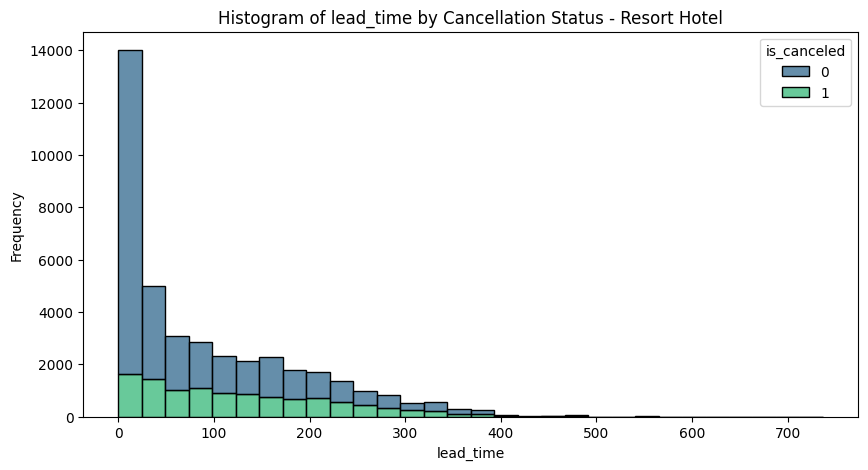

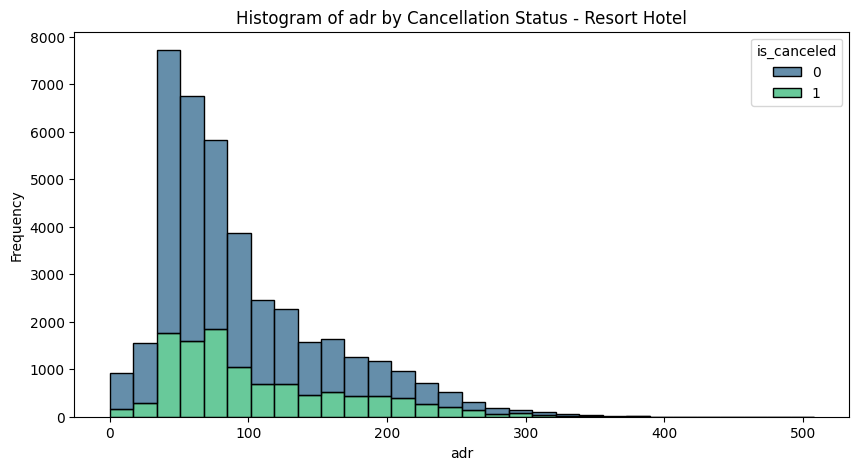

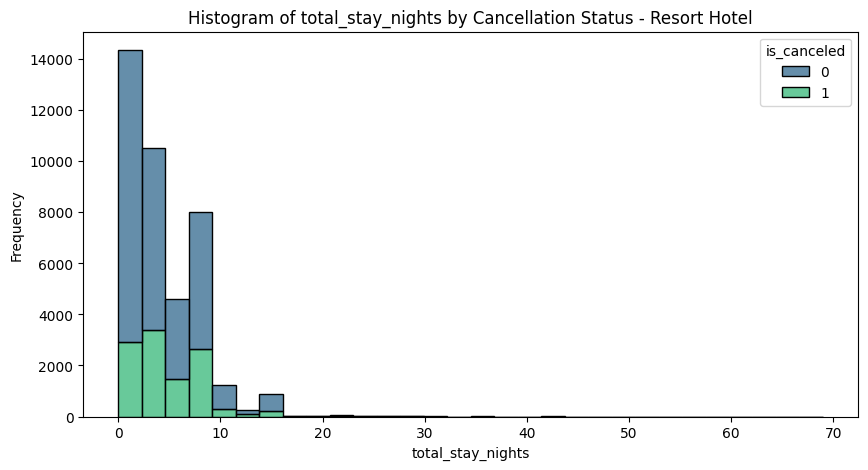

In [15]:
# EDA for City Hotel
def calculate_statistics_city():
    print("\nStatistics for City Hotel:\n")
    avg_lead_time = city_hotel['lead_time'].mean()
    avg_lead_time_canceled = city_hotel[city_hotel['is_canceled'] == 1]['lead_time'].mean()
    avg_lead_time_not_canceled = city_hotel[city_hotel['is_canceled'] == 0]['lead_time'].mean()
    avg_previous_cancellations = city_hotel['previous_cancellations'].mean()
    avg_adr = city_hotel['adr'].mean()
    avg_adr_canceled = city_hotel[city_hotel['is_canceled'] == 1]['adr'].mean()
    avg_adr_not_canceled = city_hotel[city_hotel['is_canceled'] == 0]['adr'].mean()
    avg_booking_changes = city_hotel['booking_changes'].mean()
    repeat_guest_cancellation_rate = city_hotel[city_hotel['is_repeated_guest'] == 1]['is_canceled'].mean()
    avg_lead_time_repeat = city_hotel[city_hotel['is_repeated_guest'] == 1]['lead_time'].mean()
    avg_lead_time_non_repeat = city_hotel[city_hotel['is_repeated_guest'] == 0]['lead_time'].mean()
    avg_adr_repeat = city_hotel[city_hotel['is_repeated_guest'] == 1]['adr'].mean()
    avg_adr_non_repeat = city_hotel[city_hotel['is_repeated_guest'] == 0]['adr'].mean()
    
    print(f"Average Lead Time: {avg_lead_time}")
    print(f"Average Lead Time for Canceled Bookings: {avg_lead_time_canceled}")
    print(f"Average Lead Time for Non-Canceled Bookings: {avg_lead_time_not_canceled}")
    print(f"Average Previous Cancellations: {avg_previous_cancellations}")
    print(f"Average ADR: {avg_adr}")
    print(f"Average ADR for Canceled Bookings: {avg_adr_canceled}")
    print(f"Average ADR for Non-Canceled Bookings: {avg_adr_not_canceled}")
    print(f"Average Booking Changes: {avg_booking_changes}")
    print(f"Repeat Guest Cancellation Rate: {repeat_guest_cancellation_rate}")
    print(f"Average Lead Time for Repeat Guests: {avg_lead_time_repeat}")
    print(f"Average Lead Time for Non-Repeat Guests: {avg_lead_time_non_repeat}")
    print(f"Average ADR for Repeat Guests: {avg_adr_repeat}")
    print(f"Average ADR for Non-Repeat Guests: {avg_adr_non_repeat}")

calculate_statistics_city()

def plot_distributions_city(feature):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=city_hotel, x=feature, hue='is_canceled', multiple='stack', palette='viridis', bins=30)
    plt.title(f'Histogram of {feature} by Cancellation Status - City Hotel')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

plot_distributions_city('lead_time')
plot_distributions_city('adr')
plot_distributions_city('total_stay_nights')

# EDA for Resort Hotel
def calculate_statistics_resort():
    print("\nStatistics for Resort Hotel:\n")
    avg_lead_time = resort_hotel['lead_time'].mean()
    avg_lead_time_canceled = resort_hotel[resort_hotel['is_canceled'] == 1]['lead_time'].mean()
    avg_lead_time_not_canceled = resort_hotel[resort_hotel['is_canceled'] == 0]['lead_time'].mean()
    avg_previous_cancellations = resort_hotel['previous_cancellations'].mean()
    avg_adr = resort_hotel['adr'].mean()
    avg_adr_canceled = resort_hotel[resort_hotel['is_canceled'] == 1]['adr'].mean()
    avg_adr_not_canceled = resort_hotel[resort_hotel['is_canceled'] == 0]['adr'].mean()
    avg_booking_changes = resort_hotel['booking_changes'].mean()
    repeat_guest_cancellation_rate = resort_hotel[resort_hotel['is_repeated_guest'] == 1]['is_canceled'].mean()
    avg_lead_time_repeat = resort_hotel[resort_hotel['is_repeated_guest'] == 1]['lead_time'].mean()
    avg_lead_time_non_repeat = resort_hotel[resort_hotel['is_repeated_guest'] == 0]['lead_time'].mean()
    avg_adr_repeat = resort_hotel[resort_hotel['is_repeated_guest'] == 1]['adr'].mean()
    avg_adr_non_repeat = resort_hotel[resort_hotel['is_repeated_guest'] == 0]['adr'].mean()
    
    print(f"Average Lead Time: {avg_lead_time}")
    print(f"Average Lead Time for Canceled Bookings: {avg_lead_time_canceled}")
    print(f"Average Lead Time for Non-Canceled Bookings: {avg_lead_time_not_canceled}")
    print(f"Average Previous Cancellations: {avg_previous_cancellations}")
    print(f"Average ADR: {avg_adr}")
    print(f"Average ADR for Canceled Bookings: {avg_adr_canceled}")
    print(f"Average ADR for Non-Canceled Bookings: {avg_adr_not_canceled}")
    print(f"Average Booking Changes: {avg_booking_changes}")
    print(f"Repeat Guest Cancellation Rate: {repeat_guest_cancellation_rate}")
    print(f"Average Lead Time for Repeat Guests: {avg_lead_time_repeat}")
    print(f"Average Lead Time for Non-Repeat Guests: {avg_lead_time_non_repeat}")
    print(f"Average ADR for Repeat Guests: {avg_adr_repeat}")
    print(f"Average ADR for Non-Repeat Guests: {avg_adr_non_repeat}")

calculate_statistics_resort()

def plot_distributions_resort(feature):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=resort_hotel, x=feature, hue='is_canceled', multiple='stack', palette='viridis', bins=30)
    plt.title(f'Histogram of {feature} by Cancellation Status - Resort Hotel')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

plot_distributions_resort('lead_time')
plot_distributions_resort('adr')
plot_distributions_resort('total_stay_nights')


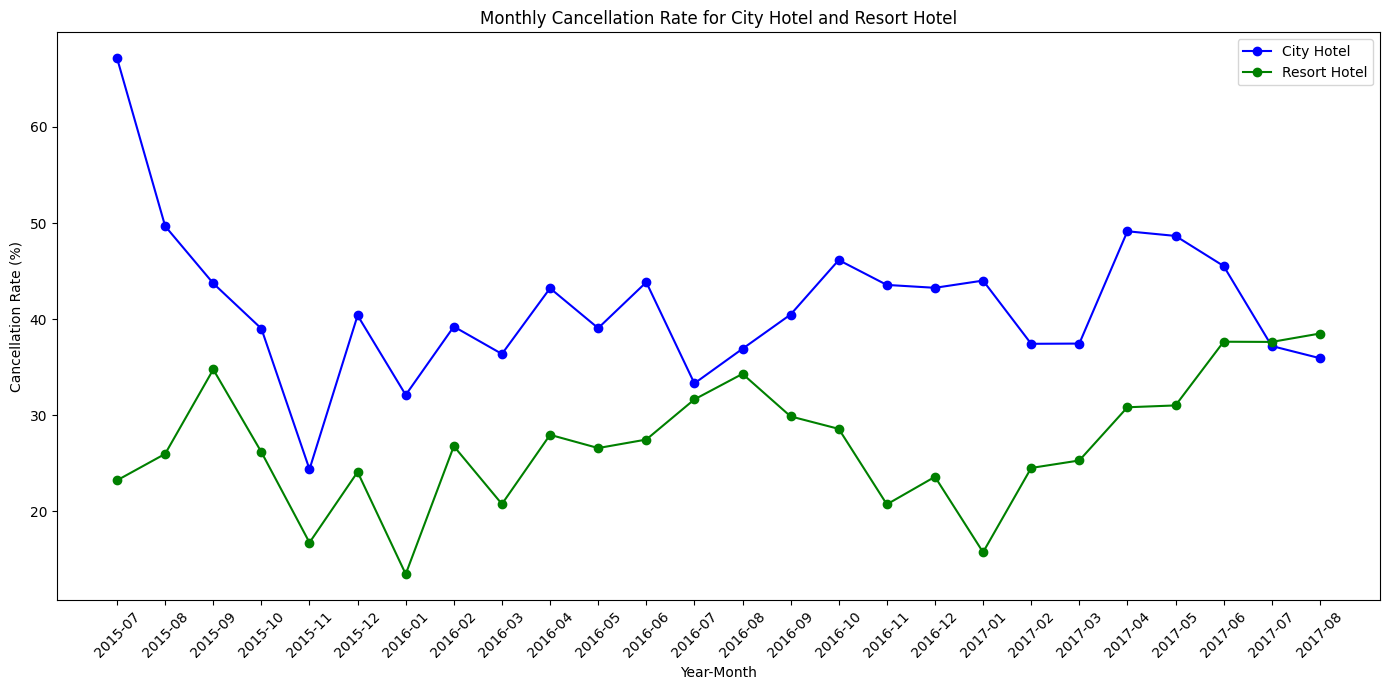

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming hotel_bookings DataFrame is already loaded

# Convert arrival_date to datetime if not already
hotel_bookings['arrival_date'] = pd.to_datetime(hotel_bookings['arrival_date'])

# Create 'year_month' column for grouping
hotel_bookings['year_month'] = hotel_bookings['arrival_date'].dt.to_period('M')

# Split dataset into 'City Hotel' and 'Resort Hotel'
city_hotel = hotel_bookings[hotel_bookings['hotel'] == 'City Hotel']
resort_hotel = hotel_bookings[hotel_bookings['hotel'] == 'Resort Hotel']

# Calculate cancellation rate for City Hotel
city_hotel_monthly = city_hotel.groupby('year_month')['is_canceled'].mean().reset_index()
city_hotel_monthly['cancellation_rate'] = city_hotel_monthly['is_canceled'] * 100

# Calculate cancellation rate for Resort Hotel
resort_hotel_monthly = resort_hotel.groupby('year_month')['is_canceled'].mean().reset_index()
resort_hotel_monthly['cancellation_rate'] = resort_hotel_monthly['is_canceled'] * 100

# Plotting the cancellation rate for City Hotel
plt.figure(figsize=(14, 7))
plt.plot(city_hotel_monthly['year_month'].astype(str), city_hotel_monthly['cancellation_rate'], marker='o', linestyle='-', label='City Hotel', color='b')
plt.plot(resort_hotel_monthly['year_month'].astype(str), resort_hotel_monthly['cancellation_rate'], marker='o', linestyle='-', label='Resort Hotel', color='g')

plt.title('Monthly Cancellation Rate for City Hotel and Resort Hotel')
plt.xlabel('Year-Month')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Combine both DataFrames for comparison
combined_monthly = pd.merge(city_hotel_monthly, resort_hotel_monthly, on='year_month', suffixes=('_city', '_resort'))

# Display combined DataFrame
combined_monthly['year_month'] = combined_monthly['year_month'].astype(str)
combined_monthly = combined_monthly[['year_month', 'cancellation_rate_city', 'cancellation_rate_resort']]


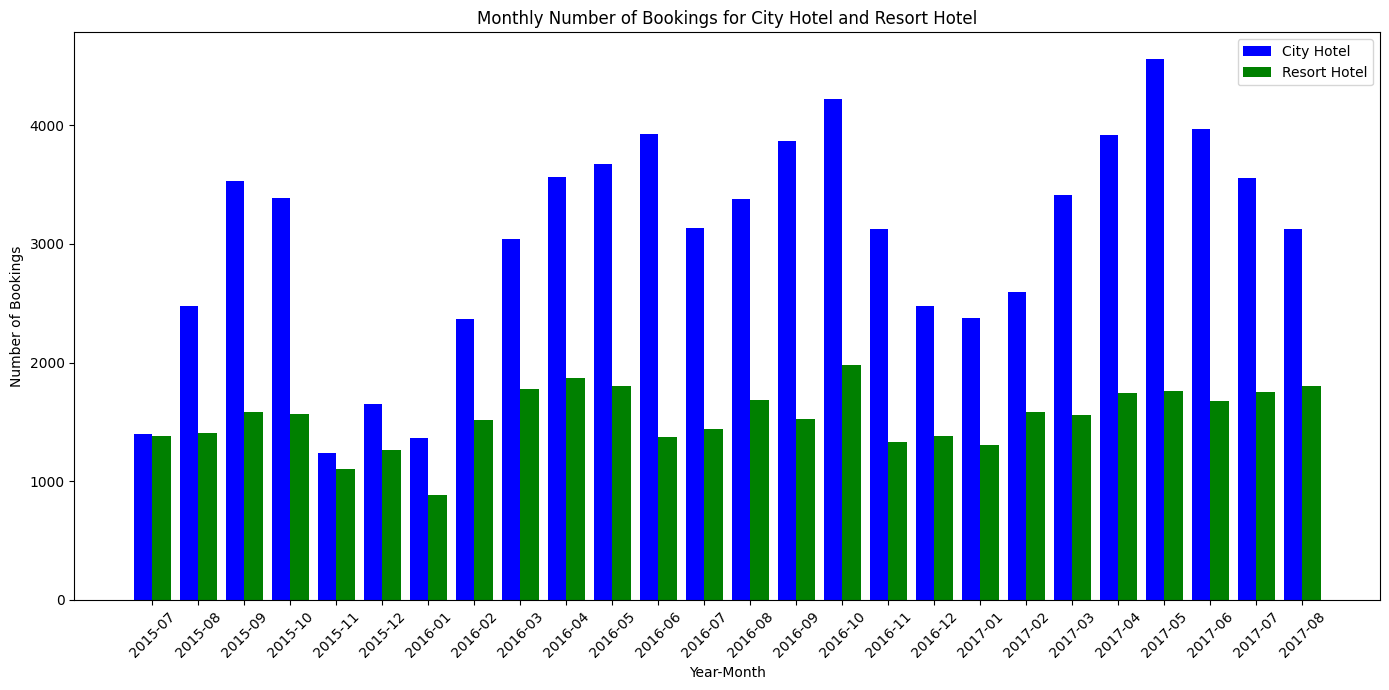

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming hotel_bookings DataFrame is already loaded

# Convert arrival_date to datetime if not already
hotel_bookings['arrival_date'] = pd.to_datetime(hotel_bookings['arrival_date'])

# Create 'year_month' column for grouping
hotel_bookings['year_month'] = hotel_bookings['arrival_date'].dt.to_period('M')

# Split dataset into 'City Hotel' and 'Resort Hotel'
city_hotel = hotel_bookings[hotel_bookings['hotel'] == 'City Hotel']
resort_hotel = hotel_bookings[hotel_bookings['hotel'] == 'Resort Hotel']

# Calculate number of bookings for City Hotel
city_hotel_monthly_bookings = city_hotel.groupby('year_month').size().reset_index(name='number_of_bookings')

# Calculate number of bookings for Resort Hotel
resort_hotel_monthly_bookings = resort_hotel.groupby('year_month').size().reset_index(name='number_of_bookings')

# Combine both DataFrames for comparison
combined_bookings = pd.merge(city_hotel_monthly_bookings, resort_hotel_monthly_bookings, on='year_month', suffixes=('_city', '_resort'))

# Plotting the number of bookings for City Hotel and Resort Hotel
combined_bookings['year_month'] = combined_bookings['year_month'].astype(str)

plt.figure(figsize=(14, 7))
bar_width = 0.4
index = range(len(combined_bookings))

plt.bar(index, combined_bookings['number_of_bookings_city'], width=bar_width, label='City Hotel', color='b', align='center')
plt.bar([i + bar_width for i in index], combined_bookings['number_of_bookings_resort'], width=bar_width, label='Resort Hotel', color='g', align='center')

plt.title('Monthly Number of Bookings for City Hotel and Resort Hotel')
plt.xlabel('Year-Month')
plt.ylabel('Number of Bookings')
plt.xticks([i + bar_width / 2 for i in index], combined_bookings['year_month'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# 6. Modeling - City Hotel

a. Feature Selection for Predicting Cancellation (is_canceled)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming city_hotel DataFrame is already loaded

# Select the relevant features
features = ['lead_time', 'stays_in_week_nights', 'adults', 'meal', 'previous_cancellations', 
            'deposit_type', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 
            'total_of_special_requests', 'room_type_change']

X_city = city_hotel[features]
y_city = city_hotel['is_canceled']



b. Preprocessing with MinMax Scaling and One-Hot Encoding, train test split

In [19]:
# Define numerical and categorical columns
numerical_cols = ['lead_time', 'stays_in_week_nights', 'adults', 'previous_cancellations', 
                  'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 
                  'total_of_special_requests']
categorical_cols = ['meal', 'deposit_type', 'room_type_change']

# Create preprocessing pipelines
numerical_pipeline = Pipeline([('scaler', MinMaxScaler())])
categorical_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [20]:
# Split data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_city, y_city, test_size=0.3, random_state=42)

c. Model Training and Cross-Validation

In [21]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Cross-validation and evaluation
f1_scorer = make_scorer(f1_score)

# Reduce the number of cross-validation folds to 3 for faster computation
for model_name, model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=f1_scorer, n_jobs=-1)
    print(f"{model_name} - Cross-Validation F1 Score: {cv_scores.mean():.4f}")

Logistic Regression - Cross-Validation F1 Score: 0.6711
KNN - Cross-Validation F1 Score: 0.7485
Random Forest - Cross-Validation F1 Score: 0.7844


d. find the best hyperparameters with GridSearchCV

In [22]:
# Define parameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'KNN': {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None]
    }
}

best_estimators = {}

for model_name, param_grid in param_grids.items():
    model = models[model_name]
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, refit=True)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")

Logistic Regression - Best Parameters: {'classifier__C': 100, 'classifier__solver': 'liblinear'}
KNN - Best Parameters: {'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Random Forest - Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}


e.  Show Results with Accuracy, Precision, Recall, F1, ROC 

Logistic Regression - Test Accuracy: 0.7828
Logistic Regression - Test Precision: 0.8573
Logistic Regression - Test Recall: 0.5741
Logistic Regression - Test F1 Score: 0.6877
Logistic Regression - Test ROC AUC: 0.8429


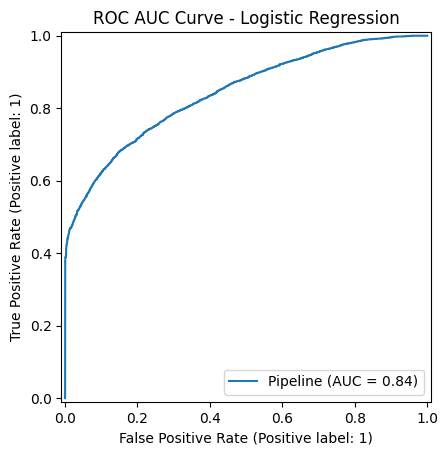

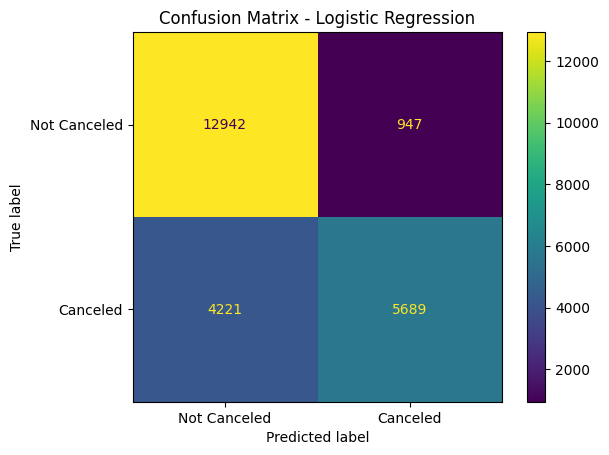

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     13889
           1       0.86      0.57      0.69      9910

    accuracy                           0.78     23799
   macro avg       0.81      0.75      0.76     23799
weighted avg       0.80      0.78      0.77     23799



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\3192953202.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


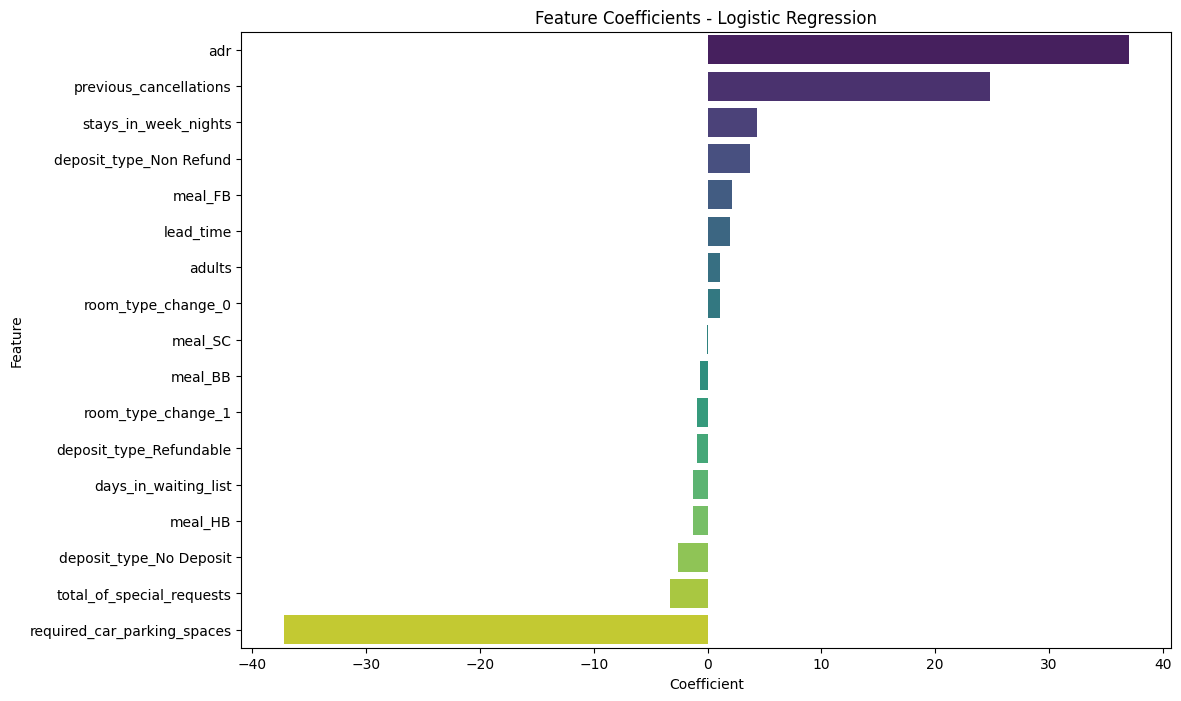

KNN - Test Accuracy: 0.8257
KNN - Test Precision: 0.8238
KNN - Test Recall: 0.7395
KNN - Test F1 Score: 0.7794
KNN - Test ROC AUC: 0.8977


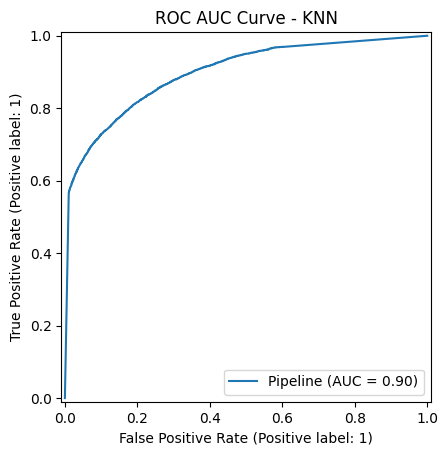

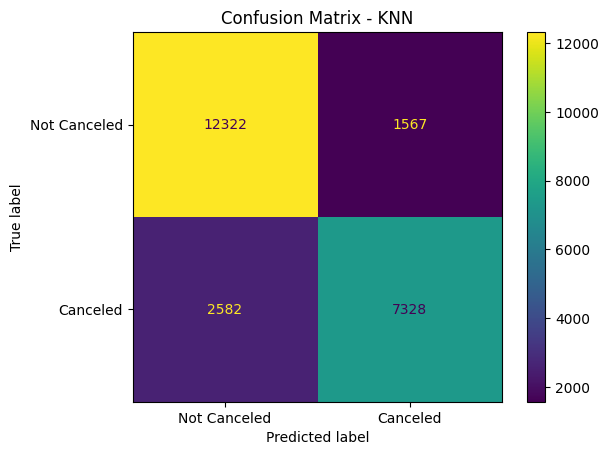

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13889
           1       0.82      0.74      0.78      9910

    accuracy                           0.83     23799
   macro avg       0.83      0.81      0.82     23799
weighted avg       0.83      0.83      0.82     23799

Random Forest - Test Accuracy: 0.8346
Random Forest - Test Precision: 0.8263
Random Forest - Test Recall: 0.7633
Random Forest - Test F1 Score: 0.7935
Random Forest - Test ROC AUC: 0.9087


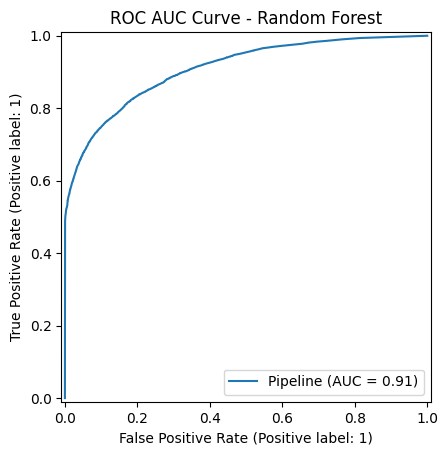

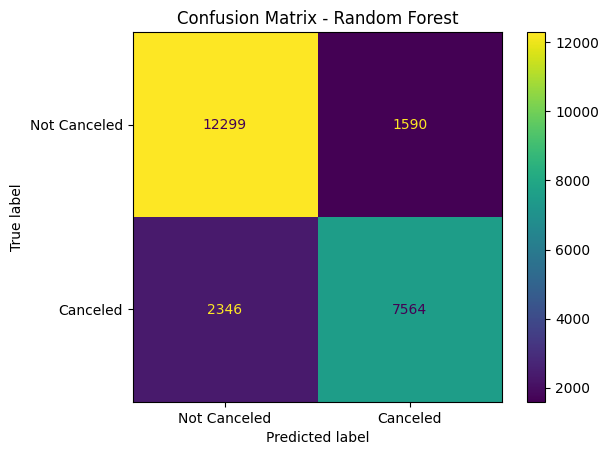

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     13889
           1       0.83      0.76      0.79      9910

    accuracy                           0.83     23799
   macro avg       0.83      0.82      0.83     23799
weighted avg       0.83      0.83      0.83     23799



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\3192953202.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


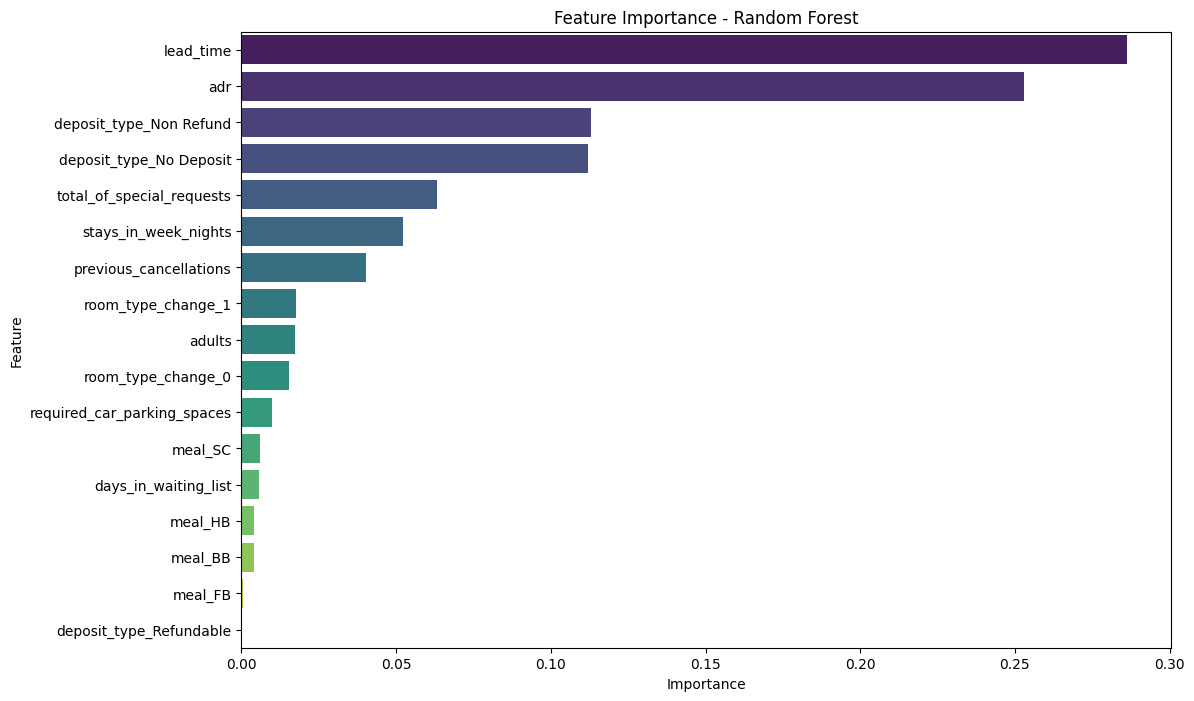

In [23]:
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Test Precision: {precision:.4f}")
    print(f"{model_name} - Test Recall: {recall:.4f}")
    print(f"{model_name} - Test F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"{model_name} - Test ROC AUC: {roc_auc:.4f}")
    
    # ROC Curve
    if y_prob is not None:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f'ROC AUC Curve - {model_name}')
        plt.show()
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Not Canceled', 'Canceled'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Feature Importance for Random Forest and Coefficients for Logistic Regression
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
        feature_names = numerical_cols + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Feature Importance - {model_name}')
        plt.show()
    
    if hasattr(model.named_steps['classifier'], 'coef_'):
        coef = model.named_steps['classifier'].coef_[0]
        feature_names = numerical_cols + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
        coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
        plt.title(f'Feature Coefficients - {model_name}')
        plt.show()


random forest remains the best model due to its highest score

f. Precision-reall trade off: for hotels, predicting a cancelled booking as not cancelled is more economically expensive than predicting a not cancelled booking as cancelled. Therefore. we Adjust the threshold to 40% in order to increase recall (minimize the number of 'not cancelled' prediction while it is cancelled)

Random Forest with 40% Threshold - Test Accuracy: 0.8230
Random Forest with 40% Threshold - Test Precision: 0.7752
Random Forest with 40% Threshold - Test Recall: 0.8099
Random Forest with 40% Threshold - Test F1 Score: 0.7921
Random Forest with 40% Threshold - Test ROC AUC: 0.9087


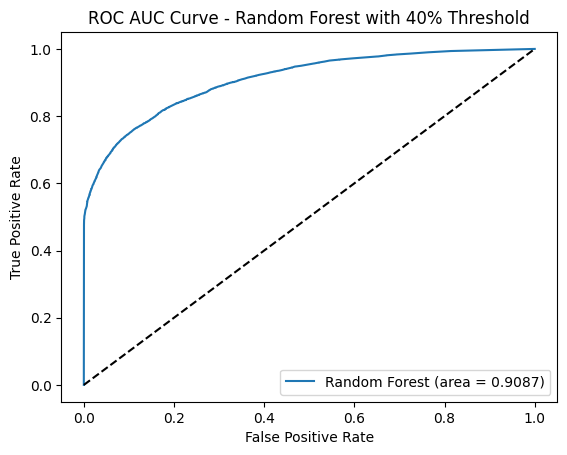

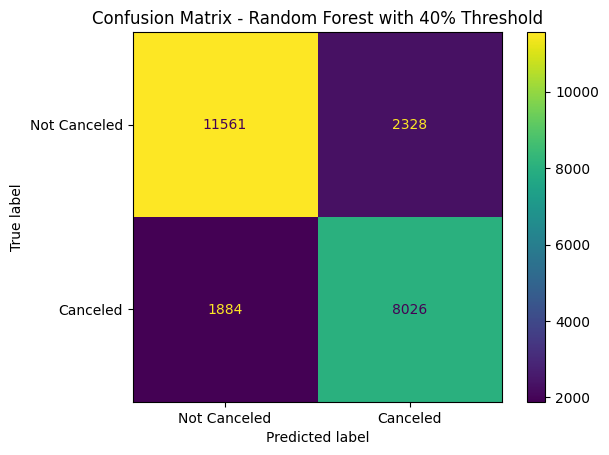

Classification Report for Random Forest with 40% Threshold:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     13889
           1       0.78      0.81      0.79      9910

    accuracy                           0.82     23799
   macro avg       0.82      0.82      0.82     23799
weighted avg       0.82      0.82      0.82     23799



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\719608326.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf, palette='viridis')


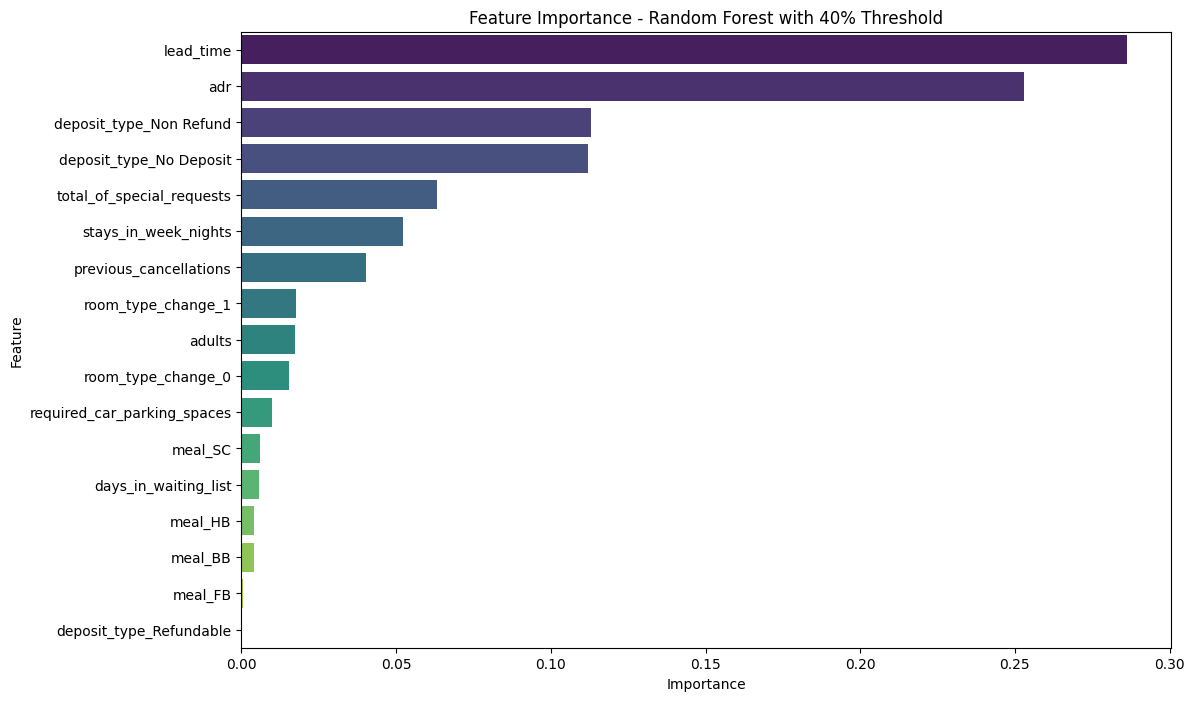

In [24]:
# Adjust threshold for Random Forest to 0.4
threshold = 0.4
rf_model = best_estimators['Random Forest']
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= threshold).astype(int)

# Evaluation Metrics for Random Forest with threshold 0.4
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"Random Forest with 40% Threshold - Test Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest with 40% Threshold - Test Precision: {precision_rf:.4f}")
print(f"Random Forest with 40% Threshold - Test Recall: {recall_rf:.4f}")
print(f"Random Forest with 40% Threshold - Test F1 Score: {f1_rf:.4f}")
print(f"Random Forest with 40% Threshold - Test ROC AUC: {roc_auc_rf:.4f}")

# ROC Curve for Random Forest with threshold 0.4
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - Random Forest with 40% Threshold')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix for Random Forest with threshold 0.4
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix - Random Forest with 40% Threshold')
plt.show()

# Classification Report for Random Forest with threshold 0.4
print("Classification Report for Random Forest with 40% Threshold:")
print(classification_report(y_test, y_pred_rf))

# Feature Importance for Random Forest with threshold 0.4
importances_rf = rf_model.named_steps['classifier'].feature_importances_
feature_names = numerical_cols + list(rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf, palette='viridis')
plt.title('Feature Importance - Random Forest with 40% Threshold')
plt.show()



F1 Score improved while recall decreases. Random forest with (40%) Threshold is the final model for city hotel.

Feature Importance or Coefficient for city hotel Models

In [25]:
# Logistic Regression Coefficients
log_reg_model = best_estimators['Logistic Regression']
coef = log_reg_model.named_steps['classifier'].coef_[0]
feature_names = numerical_cols + list(log_reg_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Display coefficients table
print("Logistic Regression Coefficients:")
print(coef_df)


Logistic Regression Coefficients:
                        Feature  Coefficient
5                           adr    37.036076
3        previous_cancellations    24.832908
1          stays_in_week_nights     4.385804
13      deposit_type_Non Refund     3.729558
9                       meal_FB     2.182295
0                     lead_time     1.991051
2                        adults     1.130729
15           room_type_change_0     1.091703
11                      meal_SC    -0.072306
8                       meal_BB    -0.634490
16           room_type_change_1    -0.914102
14      deposit_type_Refundable    -0.937792
4          days_in_waiting_list    -1.241878
10                      meal_HB    -1.297897
12      deposit_type_No Deposit    -2.614165
7     total_of_special_requests    -3.299341
6   required_car_parking_spaces   -37.240469


In [26]:
# Feature Importance for Random Forest with threshold 0.4
importances_rf = rf_model.named_steps['classifier'].feature_importances_
feature_names = numerical_cols + list(rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Display feature importance table
print("Feature Importance for Random Forest with 40% Threshold:")
print(feature_importance_df_rf)


Feature Importance for Random Forest with 40% Threshold:
                        Feature  Importance
0                     lead_time    0.286263
5                           adr    0.252851
13      deposit_type_Non Refund    0.112869
12      deposit_type_No Deposit    0.111876
7     total_of_special_requests    0.063142
1          stays_in_week_nights    0.052109
3        previous_cancellations    0.040317
16           room_type_change_1    0.017616
2                        adults    0.017164
15           room_type_change_0    0.015386
6   required_car_parking_spaces    0.010000
11                      meal_SC    0.005978
4          days_in_waiting_list    0.005823
10                      meal_HB    0.003965
8                       meal_BB    0.003956
9                       meal_FB    0.000575
14      deposit_type_Refundable    0.000109


# 7. Modeling - Resort Hotel

Prepare Data for Modeling

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant features for Resort Hotel
features_resort = ['lead_time', 'stays_in_weekend_nights', 'adults', 'meal', 'previous_cancellations', 
                   'deposit_type', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 
                   'total_of_special_requests', 'room_type_change']

X_resort = resort_hotel[features_resort]
y_resort = resort_hotel['is_canceled']

# Define numerical and categorical columns
numerical_cols_resort = ['lead_time', 'stays_in_weekend_nights', 'adults', 'previous_cancellations', 
                         'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 
                         'total_of_special_requests']
categorical_cols_resort = ['meal', 'deposit_type', 'room_type_change']

# Create preprocessing pipelines
numerical_pipeline_resort = Pipeline([('scaler', MinMaxScaler())])
categorical_pipeline_resort = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine pipelines
preprocessor_resort = ColumnTransformer([
    ('num', numerical_pipeline_resort, numerical_cols_resort),
    ('cat', categorical_pipeline_resort, categorical_cols_resort)
])

# Split data into training and test sets (70% training, 30% test)
X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_split(X_resort, y_resort, test_size=0.3, random_state=42)


Define Models and Perform Cross-Validation

In [28]:
# Define models
models_resort = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Cross-validation and evaluation
for model_name, model in models_resort.items():
    pipeline_resort = Pipeline([('preprocessor', preprocessor_resort), ('classifier', model)])
    cv_scores_resort = cross_val_score(pipeline_resort, X_train_resort, y_train_resort, cv=3, scoring='f1', n_jobs=-1)
    print(f"{model_name} - Cross-Validation F1 Score: {cv_scores_resort.mean():.4f}")


Logistic Regression - Cross-Validation F1 Score: 0.4111
KNN - Cross-Validation F1 Score: 0.5915
Random Forest - Cross-Validation F1 Score: 0.6508


Hyperparameter Tuning with GridSearchCV

In [29]:
# Define parameter grids for GridSearchCV
param_grids_resort = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'KNN': {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None]
    }
}

best_estimators_resort = {}

for model_name, param_grid in param_grids_resort.items():
    model = models_resort[model_name]
    pipeline_resort = Pipeline([('preprocessor', preprocessor_resort), ('classifier', model)])
    grid_search_resort = GridSearchCV(pipeline_resort, param_grid, cv=3, scoring='f1', n_jobs=-1, refit=True)
    grid_search_resort.fit(X_train_resort, y_train_resort)
    best_estimators_resort[model_name] = grid_search_resort.best_estimator_
    print(f"{model_name} - Best Parameters: {grid_search_resort.best_params_}")


Logistic Regression - Best Parameters: {'classifier__C': 100, 'classifier__solver': 'liblinear'}
KNN - Best Parameters: {'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}
Random Forest - Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}


Model Evaluation and Visualization

Logistic Regression - Test Accuracy: 0.7837
Logistic Regression - Test Precision: 0.7486
Logistic Regression - Test Recall: 0.3230
Logistic Regression - Test F1 Score: 0.4512
Logistic Regression - Test ROC AUC: 0.8189


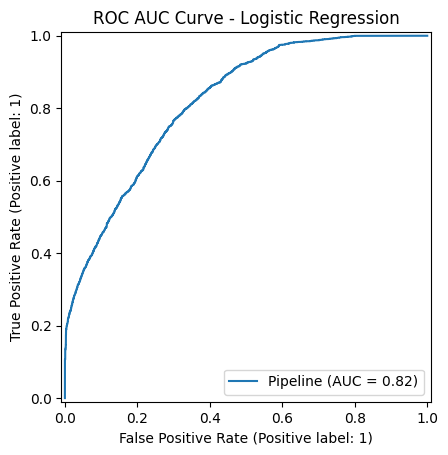

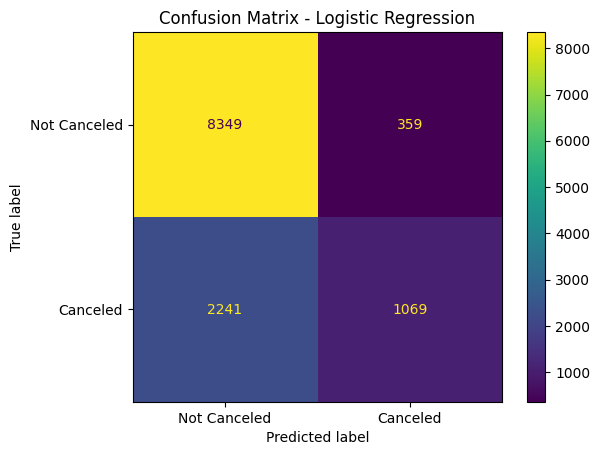

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      8708
           1       0.75      0.32      0.45      3310

    accuracy                           0.78     12018
   macro avg       0.77      0.64      0.66     12018
weighted avg       0.78      0.78      0.75     12018



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\3663255100.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df_resort, palette='viridis')


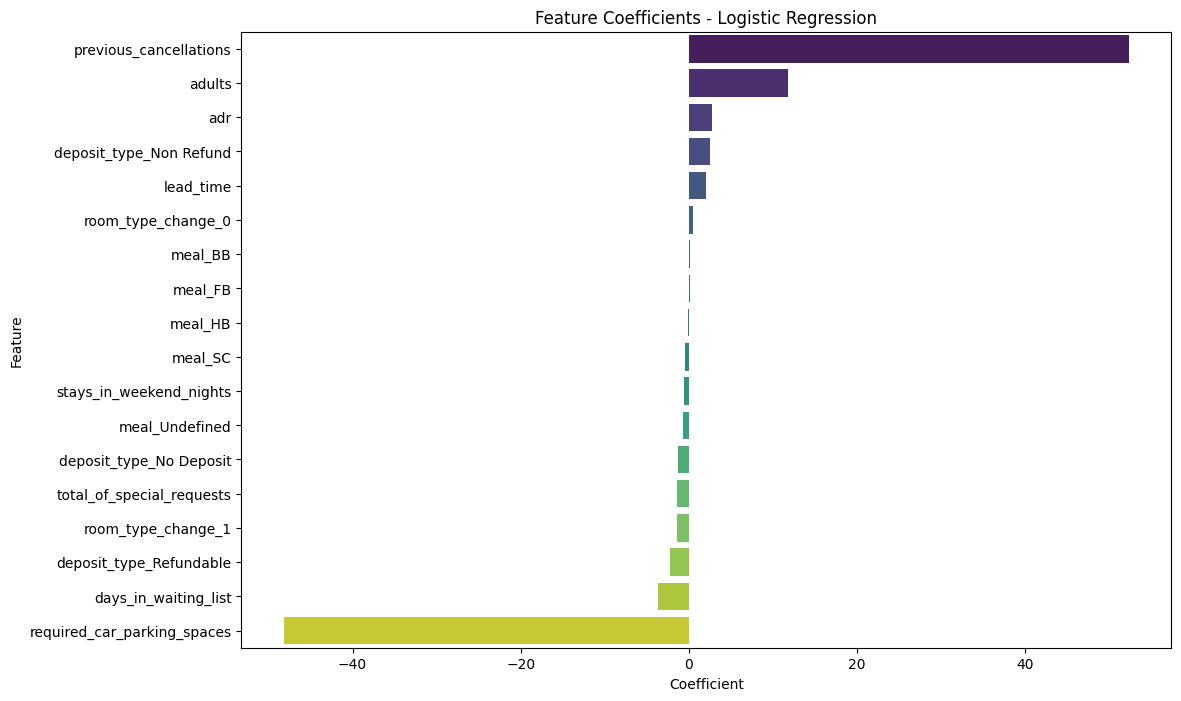

KNN - Test Accuracy: 0.8177
KNN - Test Precision: 0.6996
KNN - Test Recall: 0.5924
KNN - Test F1 Score: 0.6416
KNN - Test ROC AUC: 0.8681


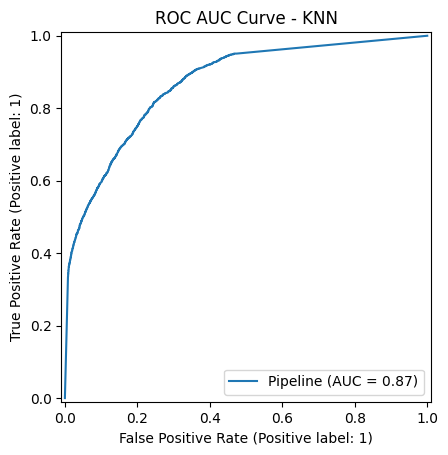

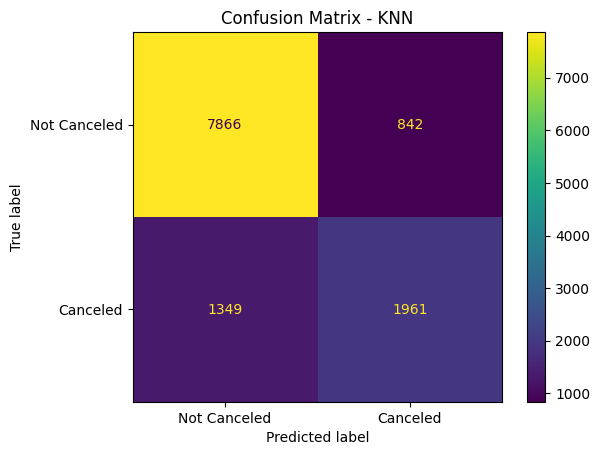

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      8708
           1       0.70      0.59      0.64      3310

    accuracy                           0.82     12018
   macro avg       0.78      0.75      0.76     12018
weighted avg       0.81      0.82      0.81     12018

Random Forest - Test Accuracy: 0.8233
Random Forest - Test Precision: 0.7083
Random Forest - Test Recall: 0.6097
Random Forest - Test F1 Score: 0.6553
Random Forest - Test ROC AUC: 0.8802


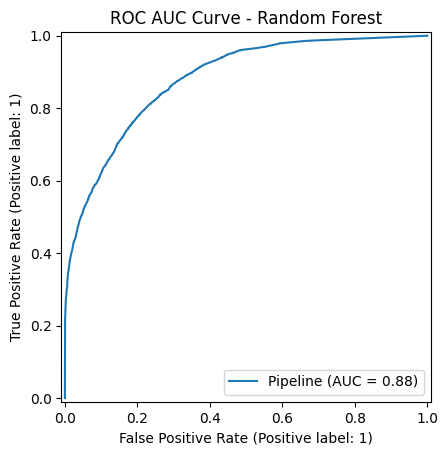

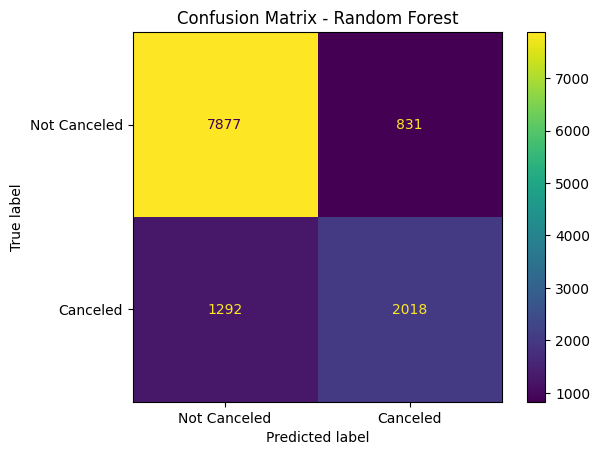

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8708
           1       0.71      0.61      0.66      3310

    accuracy                           0.82     12018
   macro avg       0.78      0.76      0.77     12018
weighted avg       0.82      0.82      0.82     12018



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\3663255100.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_resort, palette='viridis')


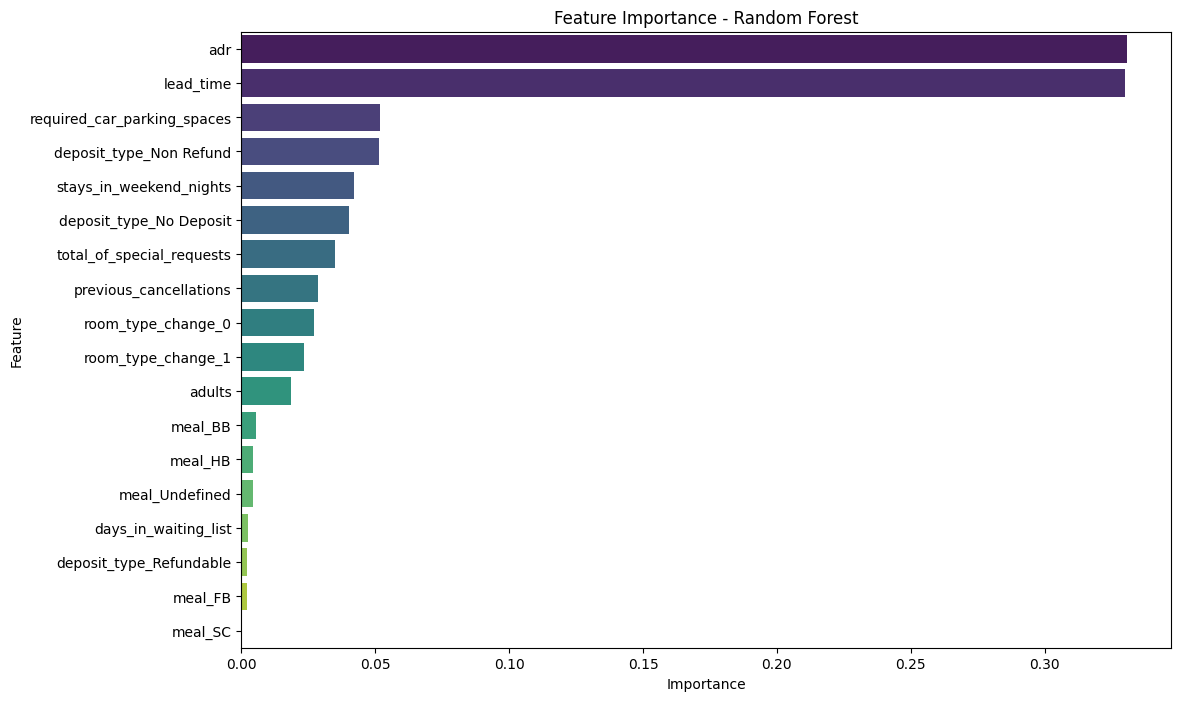

In [30]:
for model_name, model in best_estimators_resort.items():
    y_pred_resort = model.predict(X_test_resort)
    y_prob_resort = model.predict_proba(X_test_resort)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluation Metrics
    accuracy_resort = accuracy_score(y_test_resort, y_pred_resort)
    precision_resort = precision_score(y_test_resort, y_pred_resort)
    recall_resort = recall_score(y_test_resort, y_pred_resort)
    f1_resort = f1_score(y_test_resort, y_pred_resort)
    roc_auc_resort = roc_auc_score(y_test_resort, y_prob_resort) if y_prob_resort is not None else None
    
    print(f"{model_name} - Test Accuracy: {accuracy_resort:.4f}")
    print(f"{model_name} - Test Precision: {precision_resort:.4f}")
    print(f"{model_name} - Test Recall: {recall_resort:.4f}")
    print(f"{model_name} - Test F1 Score: {f1_resort:.4f}")
    if roc_auc_resort is not None:
        print(f"{model_name} - Test ROC AUC: {roc_auc_resort:.4f}")
    
    # ROC Curve
    if y_prob_resort is not None:
        RocCurveDisplay.from_estimator(model, X_test_resort, y_test_resort)
        plt.title(f'ROC AUC Curve - {model_name}')
        plt.show()
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test_resort, y_pred_resort, display_labels=['Not Canceled', 'Canceled'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_resort, y_pred_resort))

    # Feature Importance for Random Forest and Coefficients for Logistic Regression
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances_resort = model.named_steps['classifier'].feature_importances_
        feature_names_resort = numerical_cols_resort + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols_resort))
        feature_importance_df_resort = pd.DataFrame({'Feature': feature_names_resort, 'Importance': importances_resort})
        feature_importance_df_resort = feature_importance_df_resort.sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df_resort, palette='viridis')
        plt.title(f'Feature Importance - {model_name}')
        plt.show()
    
    if hasattr(model.named_steps['classifier'], 'coef_'):
        coef_resort = model.named_steps['classifier'].coef_[0]
        feature_names_resort = numerical_cols_resort + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols_resort))
        coef_df_resort = pd.DataFrame({'Feature': feature_names_resort, 'Coefficient': coef_resort})
        coef_df_resort = coef_df_resort.sort_values(by='Coefficient', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df_resort, palette='viridis')
        plt.title(f'Feature Coefficients - {model_name}')
        plt.show()


Adjust Threshold for Random Forest

Random Forest with 40% Threshold - Test Accuracy: 0.8130
Random Forest with 40% Threshold - Test Precision: 0.6509
Random Forest with 40% Threshold - Test Recall: 0.6927
Random Forest with 40% Threshold - Test F1 Score: 0.6712
Random Forest with 40% Threshold - Test ROC AUC: 0.8802


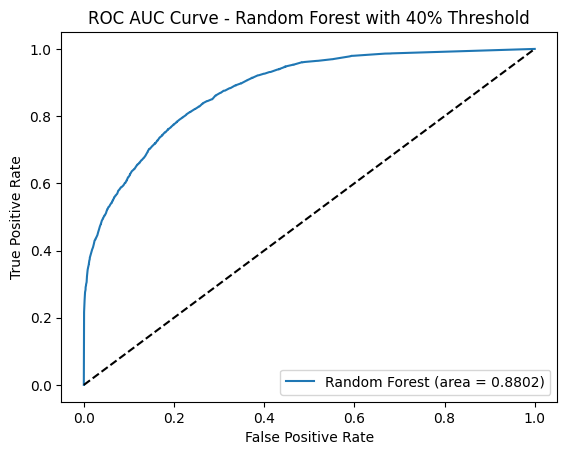

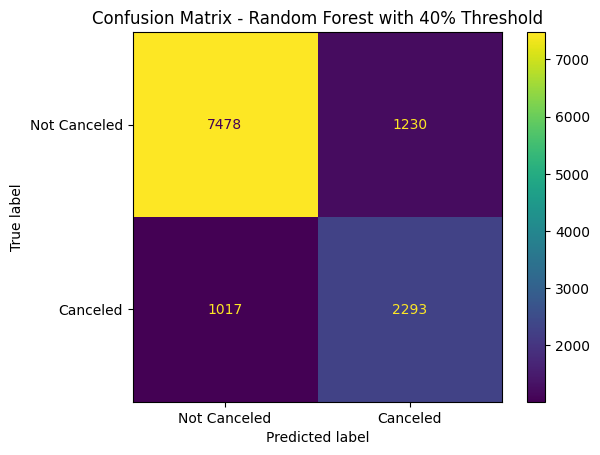

Classification Report for Random Forest with 40% Threshold:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      8708
           1       0.65      0.69      0.67      3310

    accuracy                           0.81     12018
   macro avg       0.77      0.78      0.77     12018
weighted avg       0.82      0.81      0.81     12018



C:\Users\NeilXu\AppData\Local\Temp\ipykernel_3340\1165452532.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf_resort, palette='viridis')


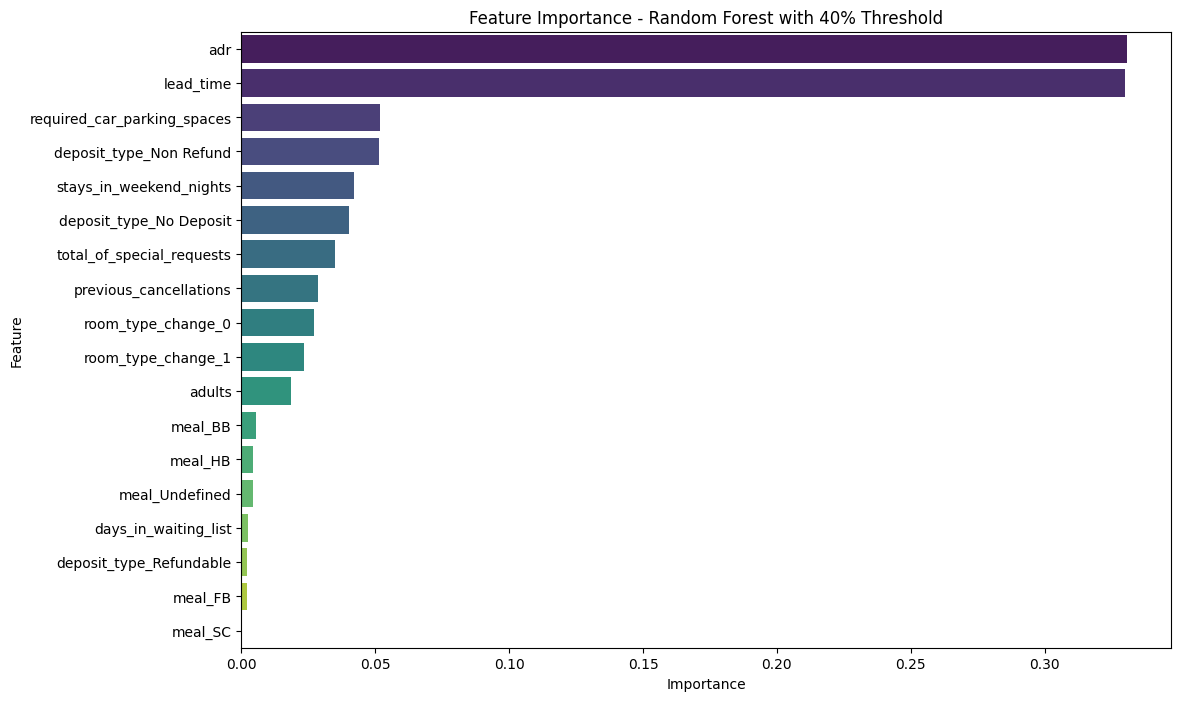

In [31]:
# Adjust threshold for Random Forest to 0.4
threshold_resort = 0.4
rf_model_resort = best_estimators_resort['Random Forest']
y_prob_rf_resort = rf_model_resort.predict_proba(X_test_resort)[:, 1]
y_pred_rf_resort = (y_prob_rf_resort >= threshold_resort).astype(int)

# Evaluation Metrics for Random Forest with threshold 0.4
accuracy_rf_resort = accuracy_score(y_test_resort, y_pred_rf_resort)
precision_rf_resort = precision_score(y_test_resort, y_pred_rf_resort)
recall_rf_resort = recall_score(y_test_resort, y_pred_rf_resort)
f1_rf_resort = f1_score(y_test_resort, y_pred_rf_resort)
roc_auc_rf_resort = roc_auc_score(y_test_resort, y_prob_rf_resort)

print(f"Random Forest with 40% Threshold - Test Accuracy: {accuracy_rf_resort:.4f}")
print(f"Random Forest with 40% Threshold - Test Precision: {precision_rf_resort:.4f}")
print(f"Random Forest with 40% Threshold - Test Recall: {recall_rf_resort:.4f}")
print(f"Random Forest with 40% Threshold - Test F1 Score: {f1_rf_resort:.4f}")
print(f"Random Forest with 40% Threshold - Test ROC AUC: {roc_auc_rf_resort:.4f}")

# ROC Curve for Random Forest with threshold 0.4
fpr_resort, tpr_resort, _ = roc_curve(y_test_resort, y_prob_rf_resort)
plt.figure()
plt.plot(fpr_resort, tpr_resort, label=f'Random Forest (area = {roc_auc_rf_resort:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - Random Forest with 40% Threshold')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix for Random Forest with threshold 0.4
ConfusionMatrixDisplay.from_predictions(y_test_resort, y_pred_rf_resort, display_labels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix - Random Forest with 40% Threshold')
plt.show()

# Classification Report for Random Forest with threshold 0.4
print("Classification Report for Random Forest with 40% Threshold:")
print(classification_report(y_test_resort, y_pred_rf_resort))

# Feature Importance for Random Forest with threshold 0.4
importances_rf_resort = rf_model_resort.named_steps['classifier'].feature_importances_
feature_names_rf_resort = numerical_cols_resort + list(rf_model_resort.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols_resort))
feature_importance_df_rf_resort = pd.DataFrame({'Feature': feature_names_rf_resort, 'Importance': importances_rf_resort})
feature_importance_df_rf_resort = feature_importance_df_rf_resort.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf_resort, palette='viridis')
plt.title('Feature Importance - Random Forest with 40% Threshold')
plt.show()


In [32]:
# Logistic Regression Coefficients for Resort Hotel
log_reg_model_resort = best_estimators_resort['Logistic Regression']
coef_resort = log_reg_model_resort.named_steps['classifier'].coef_[0]
feature_names_resort = numerical_cols_resort + list(log_reg_model_resort.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols_resort))
coef_df_resort = pd.DataFrame({'Feature': feature_names_resort, 'Coefficient': coef_resort})
coef_df_resort = coef_df_resort.sort_values(by='Coefficient', ascending=False)

# Display coefficients table for Resort Hotel
print("Logistic Regression Coefficients for Resort Hotel:")
print(coef_df_resort)



Logistic Regression Coefficients for Resort Hotel:
                        Feature  Coefficient
3        previous_cancellations    52.404569
2                        adults    11.850086
5                           adr     2.772127
14      deposit_type_Non Refund     2.568858
0                     lead_time     2.094516
16           room_type_change_0     0.492428
8                       meal_BB     0.200957
9                       meal_FB     0.172864
10                      meal_HB    -0.137587
11                      meal_SC    -0.444425
1       stays_in_weekend_nights    -0.546716
12               meal_Undefined    -0.701617
13      deposit_type_No Deposit    -1.306739
7     total_of_special_requests    -1.383611
17           room_type_change_1    -1.402235
15      deposit_type_Refundable    -2.171927
4          days_in_waiting_list    -3.702928
6   required_car_parking_spaces   -48.190474


In [33]:
# Random Forest Feature Importance for Resort Hotel
importances_rf_resort = rf_model_resort.named_steps['classifier'].feature_importances_
feature_names_rf_resort = numerical_cols_resort + list(rf_model_resort.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols_resort))
feature_importance_df_rf_resort = pd.DataFrame({'Feature': feature_names_rf_resort, 'Importance': importances_rf_resort})
feature_importance_df_rf_resort = feature_importance_df_rf_resort.sort_values(by='Importance', ascending=False)

# Display feature importance table for Resort Hotel
print("Random Forest Feature Importance for Resort Hotel:")
print(feature_importance_df_rf_resort)


Random Forest Feature Importance for Resort Hotel:
                        Feature  Importance
5                           adr    0.330778
0                     lead_time    0.329957
6   required_car_parking_spaces    0.051921
14      deposit_type_Non Refund    0.051267
1       stays_in_weekend_nights    0.041920
13      deposit_type_No Deposit    0.040067
7     total_of_special_requests    0.034829
3        previous_cancellations    0.028708
16           room_type_change_0    0.027138
17           room_type_change_1    0.023456
2                        adults    0.018491
8                       meal_BB    0.005594
10                      meal_HB    0.004498
12               meal_Undefined    0.004410
4          days_in_waiting_list    0.002319
15      deposit_type_Refundable    0.002269
9                       meal_FB    0.002109
11                      meal_SC    0.000269
